#### with including merchant state + zipcode & transactions, CC data

In [2]:
import pandas as pd
import numpy as np
import dask
import dask.dataframe as dd

## Display statistics about df
import ydata_profiling
from ydata_profiling import ProfileReport

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import pgeocode

from scipy.stats import randint
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from sklearn.model_selection import train_test_split,cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score,accuracy_score,roc_curve,auc,mean_squared_error,f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.svm import LinearSVC, LinearSVR, SVC, SVR
from sklearn.manifold import TSNE

import warnings
#hyper param
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import optuna

#Deep learning / NN libraries
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout,InputLayer, BatchNormalization,Input
from keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


# to display all cols
pd.set_option('display.max_columns', None)

2023-11-14 11:56:05.795936: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### ************************************************************************************************************************************
### 1. 🔰 Load & Transform Data
### ************************************************************************************************************************************

#### 1.1 🔰 Load & Transform Users Dataset

In [3]:
CC_users=pd.read_parquet("credit_card_users_de.parquet",engine='pyarrow')
CC_users.head()

Person  Current Age  Retirement Age  Birth Year  Birth Month  \
0  Hazel Robinson           53              66        1966           11   
1      Sasha Sadr           53              68        1966           12   
2      Saanvi Lee           81              67        1938           11   
3   Everlee Clark           63              63        1957            1   
4   Kyle Peterson           43              70        1976            9   

   Gender                   Address  Apartment           City State  Zipcode  \
0  Female             462 Rose Lane        NaN       La Verne    CA    91750   
1  Female    3606 Federal Boulevard        NaN    Little Neck    NY    11363   
2  Female           766 Third Drive        NaN    West Covina    CA    91792   
3  Female          3 Madison Street        NaN       New York    NY    10069   
4    Male  9620 Valley Stream Drive        NaN  San Francisco    CA    94117   

   Latitude  Longitude Per Capita Income - Zipcode Yearly Income - Person  \
0     34.15    -117.76                      $29278                 $59696   
1     40.76     -73.74                      $37891                 $77254   
2     34.02    -117.89                      $22681                 $33483   
3     40.71     -73.99                     $163145                $249925   
4     37.76    -122.44                      $53797                $109687   

  Total Debt  FICO Score  Num Credit Cards  
0    $127613         787                 5  
1    $191349         701                 5  
2       $196         698                 5  
3    $202328         722                 4  
4    $183855         675                 1

In [4]:
CC_users.dtypes

Person                          object
Current Age                      int64
Retirement Age                   int64
Birth Year                       int64
Birth Month                      int64
Gender                          object
Address                         object
Apartment                      float64
City                            object
State                           object
Zipcode                          int64
Latitude                       float64
Longitude                      float64
Per Capita Income - Zipcode     object
Yearly Income - Person          object
Total Debt                      object
FICO Score                       int64
Num Credit Cards                 int64
dtype: object

In [172]:
#CC_users.isna().sum()
CC_users.describe()

index_u  Current Age_u  Retirement Age_u  Birth Year_u  \
count  2000.000000    2000.000000       2000.000000   2000.000000   
mean    999.500000      45.391500         66.237500   1973.803000   
std     577.494589      18.414092          3.628867     18.421234   
min       0.000000      18.000000         50.000000   1918.000000   
25%     499.750000      30.000000         65.000000   1961.000000   
50%     999.500000      44.000000         66.000000   1975.000000   
75%    1499.250000      58.000000         68.000000   1989.000000   
max    1999.000000     101.000000         79.000000   2002.000000   

       Birth Month_u  Apartment_u   Latitude_u  Longitude_u  \
count    2000.000000   528.000000  2000.000000  2000.000000   
mean        6.439000   693.547348    37.389225   -91.554765   
std         3.565338  1897.157861     5.114324    16.283293   
min         1.000000     1.000000    20.880000  -159.410000   
25%         3.000000     5.000000    33.837500   -97.395000   
50%         7.000000    10.000000    38.250000   -86.440000   
75%        10.000000    95.250000    41.200000   -80.130000   
max        12.000000  9940.000000    61.200000   -68.670000   

       Per Capita Income - Zipcode_u  Yearly Income - Person_u   Total Debt_u  \
count                    2000.000000               2000.000000    2000.000000   
mean                    23141.928000              45715.882000   63709.694000   
std                     11324.137358              22992.615456   52254.453421   
min                         0.000000                  1.000000       0.000000   
25%                     16824.500000              32818.500000   23986.750000   
50%                     20581.000000              40744.500000   58251.000000   
75%                     26286.000000              52698.500000   89070.500000   
max                    163145.000000             307018.000000  516263.000000   

       FICO Score_u  Num Credit Cards_u  
count   2000.000000         2000.000000  
mean     709.734500            3.073000  
std       67.221949            1.637379  
min      480.000000            1.000000  
25%      681.000000            2.000000  
50%      711.500000            3.000000  
75%      753.000000            4.000000  
max      850.000000            9.000000

#### Zipcode needs to be converted to object ; Missing Values : Only Apartment has 1472 NA values ; zipcodes are populated

In [6]:
CC_users['Zipcode']=CC_users['Zipcode'].astype(str).replace(r'\.0$', '', regex=True)

In [175]:
#ProfileReport(CC_users)

In [8]:
CC_users=CC_users.reset_index()
CC_users.head()

index          Person  Current Age  Retirement Age  Birth Year  \
0      0  Hazel Robinson           53              66        1966   
1      1      Sasha Sadr           53              68        1966   
2      2      Saanvi Lee           81              67        1938   
3      3   Everlee Clark           63              63        1957   
4      4   Kyle Peterson           43              70        1976   

   Birth Month  Gender                   Address  Apartment           City  \
0           11  Female             462 Rose Lane        NaN       La Verne   
1           12  Female    3606 Federal Boulevard        NaN    Little Neck   
2           11  Female           766 Third Drive        NaN    West Covina   
3            1  Female          3 Madison Street        NaN       New York   
4            9    Male  9620 Valley Stream Drive        NaN  San Francisco   

  State Zipcode  Latitude  Longitude Per Capita Income - Zipcode  \
0    CA   91750     34.15    -117.76                      $29278   
1    NY   11363     40.76     -73.74                      $37891   
2    CA   91792     34.02    -117.89                      $22681   
3    NY   10069     40.71     -73.99                     $163145   
4    CA   94117     37.76    -122.44                      $53797   

  Yearly Income - Person Total Debt  FICO Score  Num Credit Cards  
0                 $59696    $127613         787                 5  
1                 $77254    $191349         701                 5  
2                 $33483       $196         698                 5  
3                $249925    $202328         722                 4  
4                $109687    $183855         675                 1

In [9]:
CC_users['Per Capita Income - Zipcode']= pd.to_numeric(CC_users['Per Capita Income - Zipcode'].str.replace('$',''))
CC_users['Yearly Income - Person']= pd.to_numeric(CC_users['Yearly Income - Person'].str.replace('$',''))
CC_users['Total Debt']= pd.to_numeric(CC_users['Total Debt'].str.replace('$',''))
CC_users.head()

/var/folders/0t/56tw317j52n02zljvtt1yxg00000gn/T/ipykernel_2258/1245565522.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  CC_users['Per Capita Income - Zipcode']= pd.to_numeric(CC_users['Per Capita Income - Zipcode'].str.replace('$',''))
/var/folders/0t/56tw317j52n02zljvtt1yxg00000gn/T/ipykernel_2258/1245565522.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  CC_users['Yearly Income - Person']= pd.to_numeric(CC_users['Yearly Income - Person'].str.replace('$',''))
/var/folders/0t/56tw317j52n02zljvtt1yxg00000gn/T/ipykernel_2258/1245565522.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character reg

index          Person  Current Age  Retirement Age  Birth Year  \
0      0  Hazel Robinson           53              66        1966   
1      1      Sasha Sadr           53              68        1966   
2      2      Saanvi Lee           81              67        1938   
3      3   Everlee Clark           63              63        1957   
4      4   Kyle Peterson           43              70        1976   

   Birth Month  Gender                   Address  Apartment           City  \
0           11  Female             462 Rose Lane        NaN       La Verne   
1           12  Female    3606 Federal Boulevard        NaN    Little Neck   
2           11  Female           766 Third Drive        NaN    West Covina   
3            1  Female          3 Madison Street        NaN       New York   
4            9    Male  9620 Valley Stream Drive        NaN  San Francisco   

  State Zipcode  Latitude  Longitude  Per Capita Income - Zipcode  \
0    CA   91750     34.15    -117.76                        29278   
1    NY   11363     40.76     -73.74                        37891   
2    CA   91792     34.02    -117.89                        22681   
3    NY   10069     40.71     -73.99                       163145   
4    CA   94117     37.76    -122.44                        53797   

   Yearly Income - Person  Total Debt  FICO Score  Num Credit Cards  
0                   59696      127613         787                 5  
1                   77254      191349         701                 5  
2                   33483         196         698                 5  
3                  249925      202328         722                 4  
4                  109687      183855         675                 1

#### 1.2🔰 Load & Transform Transactions Dataset

In [10]:
CC_tr=pd.read_parquet("credit_card_transaction_data_de.parquet",engine='pyarrow')
CC_tr.head()

User  Card  Year  Month  Day   Time  Amount          Use Chip  \
4136     0     0  2016      1    3  10:48  $66.48  Chip Transaction   
4137     0     0  2016      1    4  06:43  $40.02  Chip Transaction   
4138     0     0  2016      1    7  09:30  $54.11  Chip Transaction   
4139     0     0  2016      1    7  16:03  $89.48  Chip Transaction   
4140     0     0  2016      1   10  06:38  $29.15  Chip Transaction   

            Merchant Name  Merchant City Merchant State      Zip   MCC  \
4136 -3345936507911876459       La Verne             CA  91750.0  7538   
4137   -34551508091458520       La Verne             CA  91750.0  5912   
4138  4055257078481058705       La Verne             CA  91750.0  7538   
4139  3414527459579106770  Monterey Park             CA  91754.0  5651   
4140 -5475680618560174533  Monterey Park             CA  91755.0  5942   

     Errors? Is Fraud?  
4136    None        No  
4137    None        No  
4138    None        No  
4139    None        No  
4140    None        No

In [11]:
CC_tr.groupby(['Is Fraud?']).size()

Is Fraud?
No     6869425
Yes       8412
dtype: int64

#### Unbalanced dataset based on actual frauds (0.1% of dataset)

In [12]:
CC_tr.dtypes

User                int64
Card                int64
Year                int64
Month               int64
Day                 int64
Time               object
Amount             object
Use Chip           object
Merchant Name       int64
Merchant City      object
Merchant State     object
Zip               float64
MCC                 int64
Errors?            object
Is Fraud?          object
dtype: object

In [13]:
#CC_tr.isna().sum()
CC_tr['Errors?'].unique()

array([None, 'Insufficient Balance', 'Bad PIN', 'Technical Glitch',
       'Bad Expiration', 'Bad Card Number', 'Bad CVV',
       'Bad Card Number,Insufficient Balance', 'Bad Card Number,Bad CVV',
       'Insufficient Balance,Technical Glitch', 'Bad Zipcode',
       'Bad PIN,Insufficient Balance', 'Bad PIN,Technical Glitch',
       'Bad Card Number,Bad Expiration', 'Bad CVV,Insufficient Balance',
       'Bad Expiration,Insufficient Balance', 'Bad Expiration,Bad CVV',
       'Bad Expiration,Technical Glitch', 'Bad Zipcode,Technical Glitch',
       'Bad Zipcode,Insufficient Balance', 'Bad CVV,Technical Glitch',
       'Bad Card Number,Technical Glitch'], dtype=object)

#### Missing Values : Merchant State : 860764 ; Errors? :  6768768 (which is high )
#### The following transformations are necessary for CC_tr :
#### 1. Generate datetime & date only column then determine max & min transaction dates of dataset (Minimum	2016-01-01 Maximum	2019-12-31)
#### 2. Change amt column to float & strip the currency symbol
#### 3. Change zip to categorical or object type; what about geospatial distribution?
#### 4. 

In [14]:
CC_tr['transaction_date']=pd.to_datetime(CC_tr[['Year', 'Month', 'Day']])
CC_tr['transaction_time']=pd.to_datetime(CC_tr['transaction_date'].astype(str) + ' ' + CC_tr['Time'])
CC_tr.dtypes

User                         int64
Card                         int64
Year                         int64
Month                        int64
Day                          int64
Time                        object
Amount                      object
Use Chip                    object
Merchant Name                int64
Merchant City               object
Merchant State              object
Zip                        float64
MCC                          int64
Errors?                     object
Is Fraud?                   object
transaction_date    datetime64[ns]
transaction_time    datetime64[ns]
dtype: object

In [15]:
CC_tr['Amount']= pd.to_numeric(CC_tr['Amount'].str.replace('$',''))

/var/folders/0t/56tw317j52n02zljvtt1yxg00000gn/T/ipykernel_2258/3853169016.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  CC_tr['Amount']= pd.to_numeric(CC_tr['Amount'].str.replace('$',''))


In [16]:
CC_tr['Zip']=CC_tr['Zip'].astype(str).replace(r'\.0$', '', regex=True)

In [17]:
CC_tr.head()
#CC_tr.dtypes

User  Card  Year  Month  Day   Time  Amount          Use Chip  \
4136     0     0  2016      1    3  10:48   66.48  Chip Transaction   
4137     0     0  2016      1    4  06:43   40.02  Chip Transaction   
4138     0     0  2016      1    7  09:30   54.11  Chip Transaction   
4139     0     0  2016      1    7  16:03   89.48  Chip Transaction   
4140     0     0  2016      1   10  06:38   29.15  Chip Transaction   

            Merchant Name  Merchant City Merchant State    Zip   MCC Errors?  \
4136 -3345936507911876459       La Verne             CA  91750  7538    None   
4137   -34551508091458520       La Verne             CA  91750  5912    None   
4138  4055257078481058705       La Verne             CA  91750  7538    None   
4139  3414527459579106770  Monterey Park             CA  91754  5651    None   
4140 -5475680618560174533  Monterey Park             CA  91755  5942    None   

     Is Fraud? transaction_date    transaction_time  
4136        No       2016-01-03 2016-01-03 10:48:00  
4137        No       2016-01-04 2016-01-04 06:43:00  
4138        No       2016-01-07 2016-01-07 09:30:00  
4139        No       2016-01-07 2016-01-07 16:03:00  
4140        No       2016-01-10 2016-01-10 06:38:00

In [18]:
#ProfileReport(CC_tr)

#### 1.3🔰 Load & Transform Credit cards info dataset

In [19]:
CC_cards=pd.read_parquet("sd254_cards_de.parquet",engine='pyarrow')
CC_cards.head()

User  CARD INDEX  Card Brand        Card Type       Card Number  Expires  \
0     0           0        Visa            Debit  4344676511950444  12/2022   
1     0           1        Visa            Debit  4956965974959986  12/2020   
2     0           2        Visa            Debit  4582313478255491  02/2024   
3     0           3        Visa           Credit  4879494103069057  08/2024   
4     0           4  Mastercard  Debit (Prepaid)  5722874738736011  03/2009   

   CVV Has Chip  Cards Issued Credit Limit Acct Open Date  \
0  623      YES             2       $24295        09/2002   
1  393      YES             2       $21968        04/2014   
2  719      YES             2       $46414        07/2003   
3  693       NO             1       $12400        01/2003   
4   75      YES             1          $28        09/2008   

   Year PIN last Changed Card on Dark Web  
0                   2008               No  
1                   2014               No  
2                   2004               No  
3                   2012               No  
4                   2009               No

In [20]:
CC_cards.dtypes

User                      int64
CARD INDEX                int64
Card Brand               object
Card Type                object
Card Number               int64
Expires                  object
CVV                       int64
Has Chip                 object
Cards Issued              int64
Credit Limit             object
Acct Open Date           object
Year PIN last Changed     int64
Card on Dark Web         object
dtype: object

In [21]:
CC_cards['Credit Limit']= pd.to_numeric(CC_cards['Credit Limit'].str.replace('$',''))

/var/folders/0t/56tw317j52n02zljvtt1yxg00000gn/T/ipykernel_2258/1387518958.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  CC_cards['Credit Limit']= pd.to_numeric(CC_cards['Credit Limit'].str.replace('$',''))


In [22]:
CC_cards.dtypes

User                      int64
CARD INDEX                int64
Card Brand               object
Card Type                object
Card Number               int64
Expires                  object
CVV                       int64
Has Chip                 object
Cards Issued              int64
Credit Limit              int64
Acct Open Date           object
Year PIN last Changed     int64
Card on Dark Web         object
dtype: object

In [177]:
#ProfileReport(CC_cards)

#### Note that there are no duplicates in this dataset of 6146 cards; 'Card on Dark Web' has only 1 value as False

#### 1.4🔰 Join CC_tr with CC_cards (no inflation of rows since user id and card id are the joining fields & there's 1:1 mapping)

In [24]:
CC_tr.columns = [str(col) + '_tr' for col in CC_tr.columns]
CC_cards.columns = [str(col) + '_cc' for col in CC_cards.columns]
CC_users.columns = [str(col) + '_u' for col in CC_users.columns]
print(CC_tr.columns, CC_cards.columns, CC_users.columns)

Index(['User_tr', 'Card_tr', 'Year_tr', 'Month_tr', 'Day_tr', 'Time_tr',
       'Amount_tr', 'Use Chip_tr', 'Merchant Name_tr', 'Merchant City_tr',
       'Merchant State_tr', 'Zip_tr', 'MCC_tr', 'Errors?_tr', 'Is Fraud?_tr',
       'transaction_date_tr', 'transaction_time_tr'],
      dtype='object') Index(['User_cc', 'CARD INDEX_cc', 'Card Brand_cc', 'Card Type_cc',
       'Card Number_cc', 'Expires_cc', 'CVV_cc', 'Has Chip_cc',
       'Cards Issued_cc', 'Credit Limit_cc', 'Acct Open Date_cc',
       'Year PIN last Changed_cc', 'Card on Dark Web_cc'],
      dtype='object') Index(['index_u', 'Person_u', 'Current Age_u', 'Retirement Age_u',
       'Birth Year_u', 'Birth Month_u', 'Gender_u', 'Address_u', 'Apartment_u',
       'City_u', 'State_u', 'Zipcode_u', 'Latitude_u', 'Longitude_u',
       'Per Capita Income - Zipcode_u', 'Yearly Income - Person_u',
       'Total Debt_u', 'FICO Score_u', 'Num Credit Cards_u'],
      dtype='object')


In [25]:
df_merged_1 = pd.merge(CC_tr,
                    CC_cards,
                    left_on=['User_tr','Card_tr'],right_on=['User_cc','CARD INDEX_cc'],how='left')
df_merged_1.shape

(6877837, 30)

In [26]:
df_merged = pd.merge(df_merged_1,
                    CC_users,
                    left_on=['User_tr'],right_on=['index_u'],how='left')
df_merged.shape

(6877837, 49)

In [27]:
df_merged.columns

Index(['User_tr', 'Card_tr', 'Year_tr', 'Month_tr', 'Day_tr', 'Time_tr',
       'Amount_tr', 'Use Chip_tr', 'Merchant Name_tr', 'Merchant City_tr',
       'Merchant State_tr', 'Zip_tr', 'MCC_tr', 'Errors?_tr', 'Is Fraud?_tr',
       'transaction_date_tr', 'transaction_time_tr', 'User_cc',
       'CARD INDEX_cc', 'Card Brand_cc', 'Card Type_cc', 'Card Number_cc',
       'Expires_cc', 'CVV_cc', 'Has Chip_cc', 'Cards Issued_cc',
       'Credit Limit_cc', 'Acct Open Date_cc', 'Year PIN last Changed_cc',
       'Card on Dark Web_cc', 'index_u', 'Person_u', 'Current Age_u',
       'Retirement Age_u', 'Birth Year_u', 'Birth Month_u', 'Gender_u',
       'Address_u', 'Apartment_u', 'City_u', 'State_u', 'Zipcode_u',
       'Latitude_u', 'Longitude_u', 'Per Capita Income - Zipcode_u',
       'Yearly Income - Person_u', 'Total Debt_u', 'FICO Score_u',
       'Num Credit Cards_u'],
      dtype='object')

In [28]:
df_merged.dtypes

User_tr                                   int64
Card_tr                                   int64
Year_tr                                   int64
Month_tr                                  int64
Day_tr                                    int64
Time_tr                                  object
Amount_tr                               float64
Use Chip_tr                              object
Merchant Name_tr                          int64
Merchant City_tr                         object
Merchant State_tr                        object
Zip_tr                                   object
MCC_tr                                    int64
Errors?_tr                               object
Is Fraud?_tr                             object
transaction_date_tr              datetime64[ns]
transaction_time_tr              datetime64[ns]
User_cc                                   int64
CARD INDEX_cc                             int64
Card Brand_cc                            object
Card Type_cc                            

In [29]:
df_merged['Acct Open Date_cc']=df_merged['Acct Open Date_cc'].astype('datetime64[ns]')
df_merged['Expires_cc']=df_merged['Expires_cc'].astype('datetime64[ns]')

In [30]:
df_merged.head()

User_tr  Card_tr  Year_tr  Month_tr  Day_tr Time_tr  Amount_tr  \
0        0        0     2016         1       3   10:48      66.48   
1        0        0     2016         1       4   06:43      40.02   
2        0        0     2016         1       7   09:30      54.11   
3        0        0     2016         1       7   16:03      89.48   
4        0        0     2016         1      10   06:38      29.15   

        Use Chip_tr     Merchant Name_tr Merchant City_tr Merchant State_tr  \
0  Chip Transaction -3345936507911876459         La Verne                CA   
1  Chip Transaction   -34551508091458520         La Verne                CA   
2  Chip Transaction  4055257078481058705         La Verne                CA   
3  Chip Transaction  3414527459579106770    Monterey Park                CA   
4  Chip Transaction -5475680618560174533    Monterey Park                CA   

  Zip_tr  MCC_tr Errors?_tr Is Fraud?_tr transaction_date_tr  \
0  91750    7538       None           No          2016-01-03   
1  91750    5912       None           No          2016-01-04   
2  91750    7538       None           No          2016-01-07   
3  91754    5651       None           No          2016-01-07   
4  91755    5942       None           No          2016-01-10   

  transaction_time_tr  User_cc  CARD INDEX_cc Card Brand_cc Card Type_cc  \
0 2016-01-03 10:48:00        0              0          Visa        Debit   
1 2016-01-04 06:43:00        0              0          Visa        Debit   
2 2016-01-07 09:30:00        0              0          Visa        Debit   
3 2016-01-07 16:03:00        0              0          Visa        Debit   
4 2016-01-10 06:38:00        0              0          Visa        Debit   

     Card Number_cc Expires_cc  CVV_cc Has Chip_cc  Cards Issued_cc  \
0  4344676511950444 2022-12-01     623         YES                2   
1  4344676511950444 2022-12-01     623         YES                2   
2  4344676511950444 2022-12-01     623         YES                2   
3  4344676511950444 2022-12-01     623         YES                2   
4  4344676511950444 2022-12-01     623         YES                2   

   Credit Limit_cc Acct Open Date_cc  Year PIN last Changed_cc  \
0            24295        2002-09-01                      2008   
1            24295        2002-09-01                      2008   
2            24295        2002-09-01                      2008   
3            24295        2002-09-01                      2008   
4            24295        2002-09-01                      2008   

  Card on Dark Web_cc  index_u        Person_u  Current Age_u  \
0                  No        0  Hazel Robinson             53   
1                  No        0  Hazel Robinson             53   
2                  No        0  Hazel Robinson             53   
3                  No        0  Hazel Robinson             53   
4                  No        0  Hazel Robinson             53   

   Retirement Age_u  Birth Year_u  Birth Month_u Gender_u      Address_u  \
0                66          1966             11   Female  462 Rose Lane   
1                66          1966             11   Female  462 Rose Lane   
2                66          1966             11   Female  462 Rose Lane   
3                66          1966             11   Female  462 Rose Lane   
4                66          1966             11   Female  462 Rose Lane   

   Apartment_u    City_u State_u Zipcode_u  Latitude_u  Longitude_u  \
0          NaN  La Verne      CA     91750       34.15      -117.76   
1          NaN  La Verne      CA     91750       34.15      -117.76   
2          NaN  La Verne      CA     91750       34.15      -117.76   
3          NaN  La Verne      CA     91750       34.15      -117.76   
4          NaN  La Verne      CA     91750       34.15      -117.76   

   Per Capita Income - Zipcode_u  Yearly Income - Person_u  Total Debt_u  \
0                          29278                     59696        127613   
1                   

### ************************************************************************************************************************************
### 2.🔰 EDA (analysis of fraud transactions)
### ************************************************************************************************************************************

In [31]:
df_merged_copy=df_merged.copy()

In [32]:
df_merged=df_merged_copy.copy()

#### Fraud vs Day of Week
#### Fraud vs Hour of Day
#### Fraud vs Month of Year 
#### Fraud vs Year 

/var/folders/0t/56tw317j52n02zljvtt1yxg00000gn/T/ipykernel_2258/2400053471.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['',"Mon","Tue","Wed","Thu","Fri","Sat","Sun"])


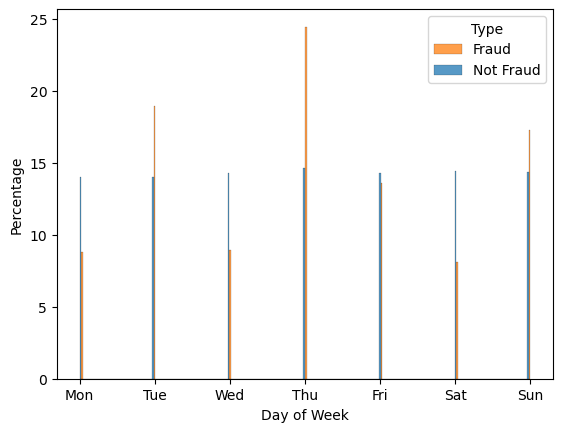

In [33]:
#day of week vs fraud
df_merged['day_name']=pd.to_datetime(df_merged['transaction_date_tr']).dt.dayofweek
ax=sns.histplot(data=df_merged, x="day_name", hue="Is Fraud?_tr", common_norm=False,stat='percent',multiple='dodge')
ax.set_xticklabels(['',"Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
ax.set_ylabel('Percentage')
ax.set_xlabel('Day of Week')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

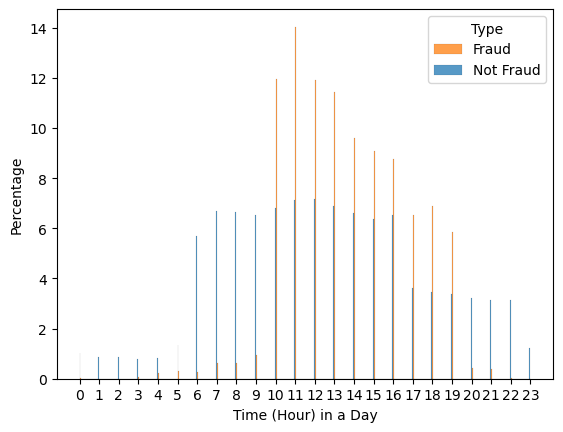

In [34]:
#time vs fraud
df_merged['hour']=pd.to_datetime(df_merged['transaction_time_tr']).dt.hour
ax=sns.histplot(data=df_merged, x="hour", hue="Is Fraud?_tr", common_norm=False,stat='percent',multiple='dodge')
ax.set_ylabel('Percentage')
ax.set_xlabel('Time (Hour) in a Day')
plt.xticks(np.arange(0,24,1))
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

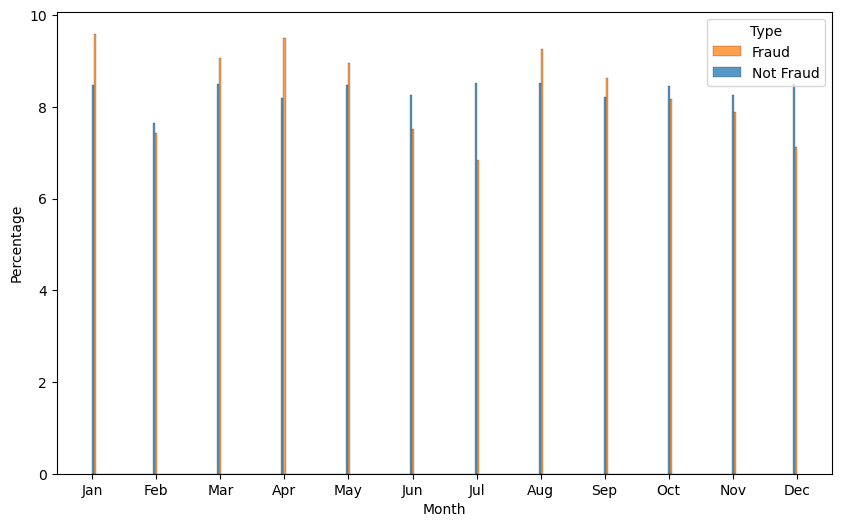

In [35]:
#month vs fraud
plt.figure(figsize=(10,6))
#df_merged['month']=pd.to_datetime(df_merged['transaction_date_tr']).dt.month
ax=sns.histplot(data=df_merged, x="Month_tr", hue="Is Fraud?_tr", common_norm=False,stat='percent',multiple='dodge')
ax.set_ylabel('Percentage')
ax.set_xlabel('Month')
plt.xticks(np.arange(1,13,1))
ax.set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul",'Aug','Sep','Oct','Nov','Dec'])
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

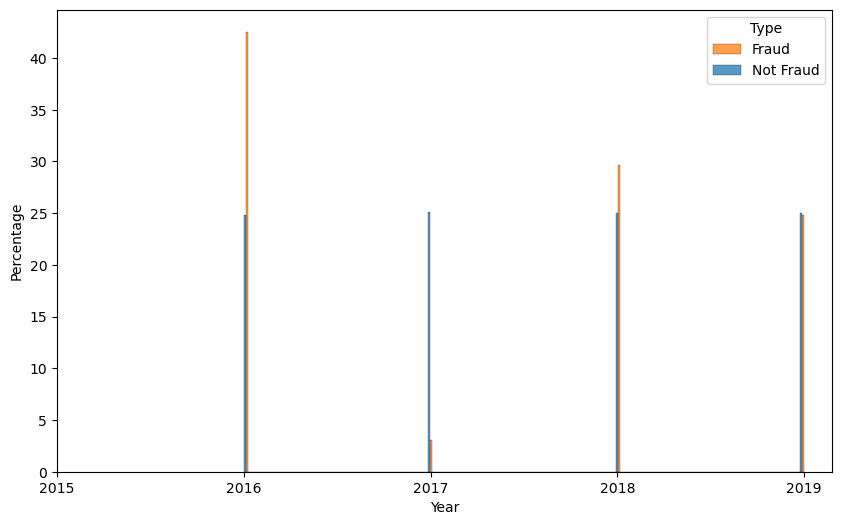

In [36]:
#year vs fraud
plt.figure(figsize=(10,6))
ax=sns.histplot(data=df_merged, x="Year_tr", hue="Is Fraud?_tr", common_norm=False,stat='percent',multiple='dodge')
ax.set_ylabel('Percentage')
ax.set_xlabel('Year')
plt.xticks(np.arange(2015,2020,1))
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

#### Fraud vs Account Age
#### Fraud vs Days to Expiry
#### Fraud vs Card Index
#### Fraud vs Card Brand
#### Fraud vs Card Type
#### Fraud vs Has Chip
#### Fraud vs Use Chip
#### Fraud vs Credit limit
#### Fraud vs Amt of transaction
#### Fraud vs year pin was changed last

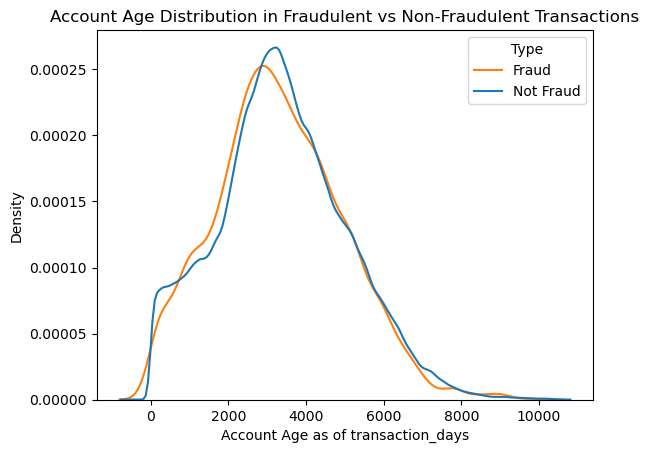

In [37]:
# accnt age vs fraud
#converting to timedelta with difference
df_merged['Accntage_asof_transaction_days']=df_merged['transaction_date_tr'] - df_merged['Acct Open Date_cc']
#converting timedelta column into int
df_merged['Accntage_asof_transaction_days']=df_merged['Accntage_asof_transaction_days'].dt.days
#Plotting kde plot
ax=sns.kdeplot(x='Accntage_asof_transaction_days',data=df_merged, hue='Is Fraud?_tr', common_norm=False)
ax.set_xlabel('Account Age as of transaction_days')
ax.set_ylabel('Density')
plt.title('Account Age Distribution in Fraudulent vs Non-Fraudulent Transactions')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

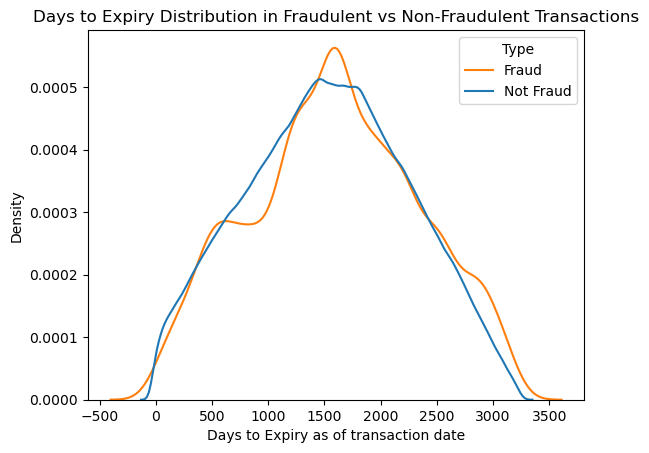

In [38]:
# days_to_expiry vs fraud
#converting to timedelta with difference
df_merged['DaysToExpiry_asof_transaction_days']= df_merged['Expires_cc'] - df_merged['transaction_date_tr']
#converting timedelta column into int
df_merged['DaysToExpiry_asof_transaction_days']=df_merged['DaysToExpiry_asof_transaction_days'].dt.days
#Plotting kde plot
ax=sns.kdeplot(x='DaysToExpiry_asof_transaction_days',data=df_merged, hue='Is Fraud?_tr', common_norm=False)
ax.set_xlabel('Days to Expiry as of transaction date')
ax.set_ylabel('Density')
#plt.xticks(np.arange(-500,100,50))
plt.title('Days to Expiry Distribution in Fraudulent vs Non-Fraudulent Transactions')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

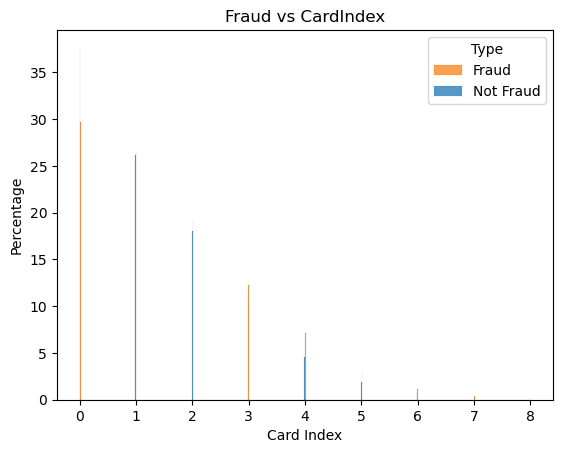

In [39]:
#Fraud vs Card Index
ax=sns.histplot(data=df_merged, x="Card_tr", hue="Is Fraud?_tr", common_norm=False,stat='percent',multiple='dodge')
ax.set_ylabel('Percentage')
ax.set_xlabel('Card Index')
plt.title('Fraud vs CardIndex')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

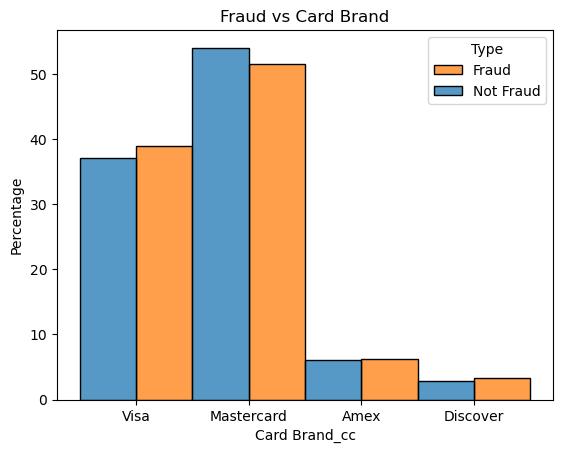

In [40]:
#Fraud vs Card Brand
ax=sns.histplot(data=df_merged, x="Card Brand_cc", hue="Is Fraud?_tr", common_norm=False,stat='percent',multiple='dodge')
ax.set_ylabel('Percentage')
ax.set_xlabel('Card Brand_cc')
plt.title('Fraud vs Card Brand')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

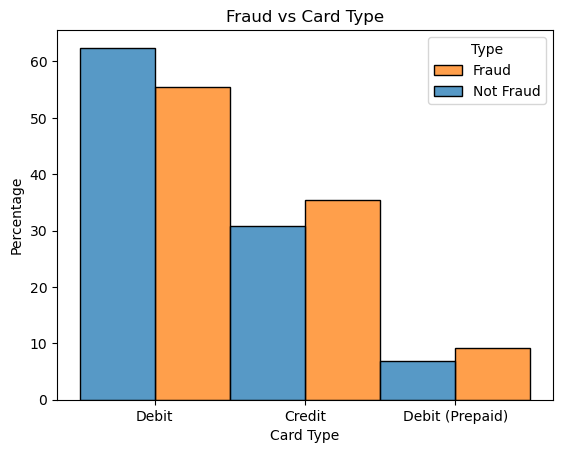

In [41]:
#Fraud vs Card Type
ax=sns.histplot(data=df_merged, x="Card Type_cc", hue="Is Fraud?_tr", common_norm=False,stat='percent',multiple='dodge')
ax.set_ylabel('Percentage')
ax.set_xlabel('Card Type')
plt.title('Fraud vs Card Type')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

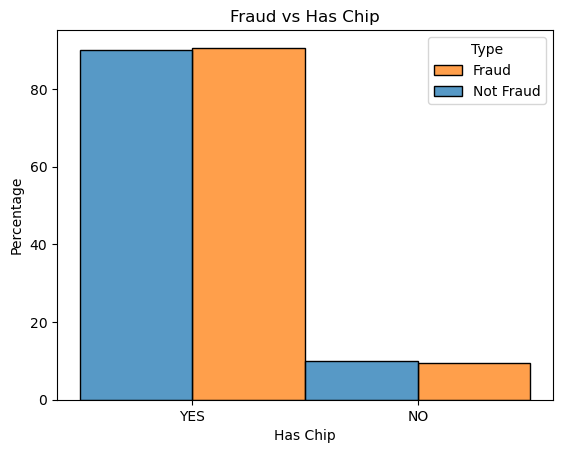

In [42]:
#Fraud vs Has Chip
ax=sns.histplot(data=df_merged, x="Has Chip_cc", hue="Is Fraud?_tr", common_norm=False,stat='percent',multiple='dodge')
ax.set_ylabel('Percentage')
ax.set_xlabel('Has Chip')
plt.title('Fraud vs Has Chip')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

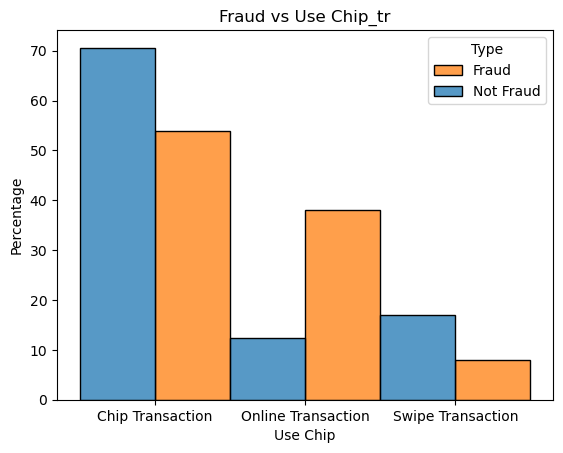

In [43]:
#Fraud vs Use Chip
ax=sns.histplot(data=df_merged, x="Use Chip_tr", hue="Is Fraud?_tr", common_norm=False,stat='percent',multiple='dodge')
ax.set_ylabel('Percentage')
ax.set_xlabel('Use Chip')
plt.title('Fraud vs Use Chip_tr')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

#### the above definitely shows Online Transaction is more prone to frauds vs chip / swipe transactions

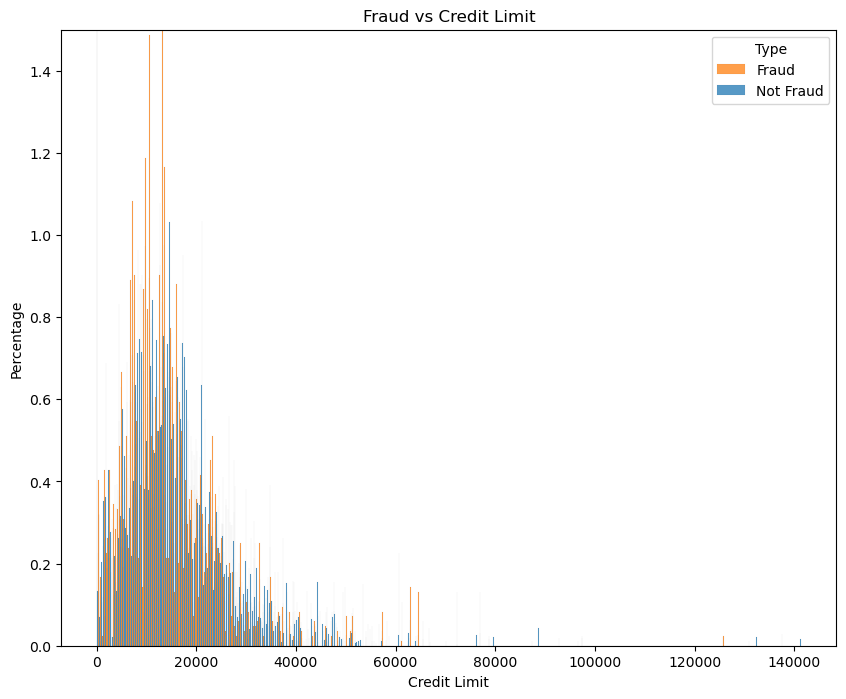

In [44]:
#Fraud vs Credit Limit
plt.figure(figsize=(10,8))
ax=sns.histplot(data=df_merged, x="Credit Limit_cc", hue="Is Fraud?_tr", common_norm=False,stat='percent',multiple='dodge')
ax.set_ylabel('Percentage')
ax.set_xlabel('Credit Limit')
#plt.ylim(0, 60000) # for count
plt.ylim(0, 1.50)
plt.title('Fraud vs Credit Limit')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

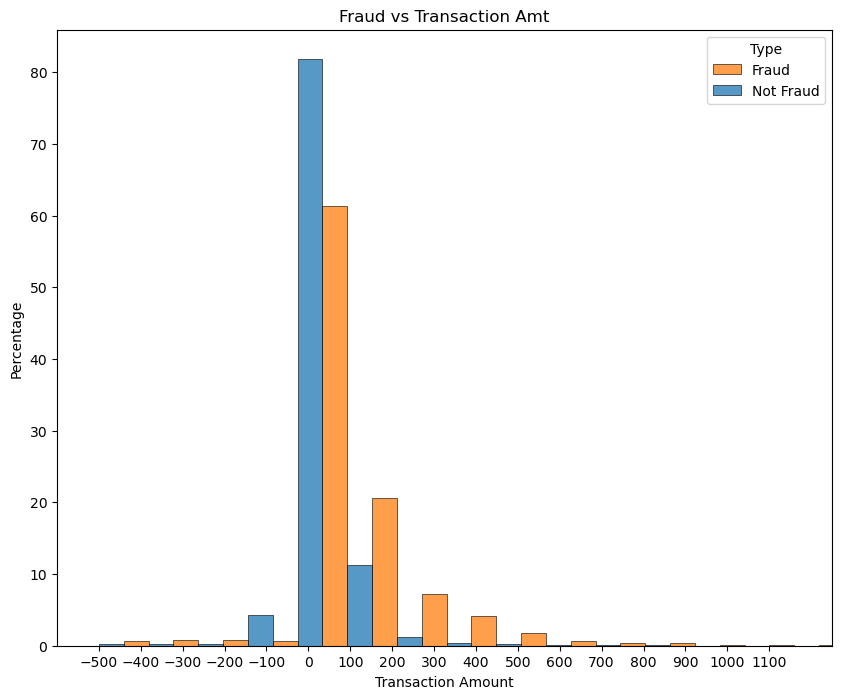

In [45]:
#Fraud vs Amt of transaction
plt.figure(figsize=(10,8))
ax=sns.histplot(data=df_merged, x="Amount_tr", hue="Is Fraud?_tr", common_norm=False,stat='percent',bins=60,multiple='dodge')
ax.set_ylabel('Percentage')
ax.set_xlabel('Transaction Amount')
#plt.ylim(0, 60000) # for count
#plt.ylim(0, 1.50)
plt.xlim(-600, 1250)
plt.xticks(np.arange(-500,1200,100))
plt.title('Fraud vs Transaction Amt')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

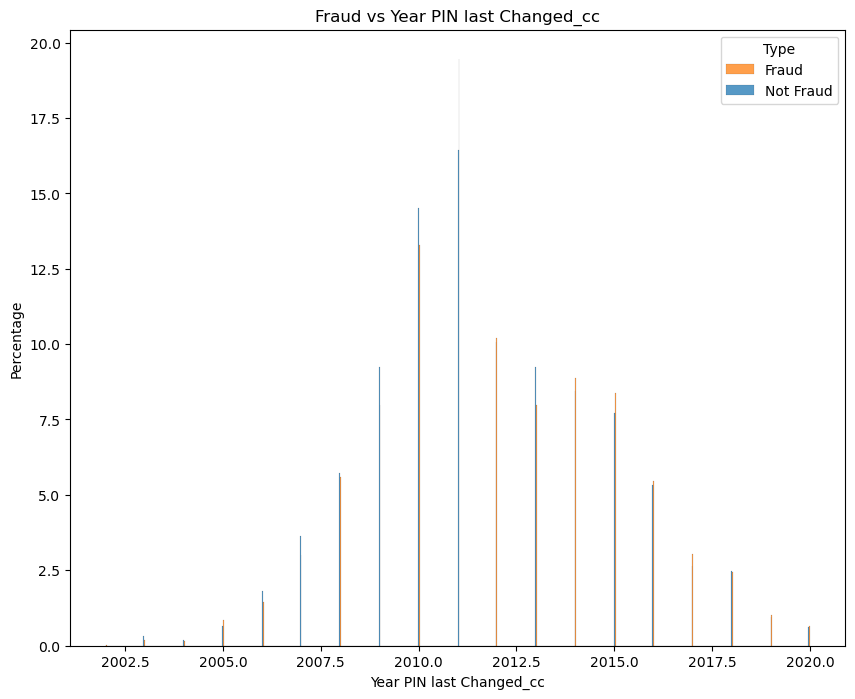

In [46]:
#Fraud vs year pin was changed last
plt.figure(figsize=(10,8))
ax=sns.histplot(data=df_merged, x="Year PIN last Changed_cc", hue="Is Fraud?_tr", common_norm=False,stat='percent',multiple='dodge')
ax.set_ylabel('Percentage')
ax.set_xlabel('Year PIN last Changed_cc')
#plt.ylim(0, 60000) # for count
#plt.ylim(0, 1.50)
#plt.xlim(0, 1250)
plt.title('Fraud vs Year PIN last Changed_cc')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

In [47]:
df_merged_EDAcomplete3DFs=df_merged.copy()

In [48]:
df_merged=df_merged_EDAcomplete3DFs.copy()

In [185]:
#df_merged.isna().sum()

#### Fraud vs Merchant City - User City Same or not
#### Fraud vs Merchant State - User State Same or not
#### Fraud vs Online Transaction or not (using Merchant_city_tr)
#### Fraud vs Current Age_u, Gender_u, Total Debt_u, Yearly Income - Person_u
#### Fraud vs  Distance between User & Merchant Zipcodes (distances)

Current Age_u                             int64
Retirement Age_u                          int64
Birth Year_u                              int64
Birth Month_u                             int64
Gender_u                                 object
Address_u                                object
Apartment_u                             float64
City_u                                   object
State_u                                  object
Zipcode_u                                object
Latitude_u                              float64
Longitude_u                             float64
Per Capita Income - Zipcode_u            object
Yearly Income - Person_u                 object
Total Debt_u                             object


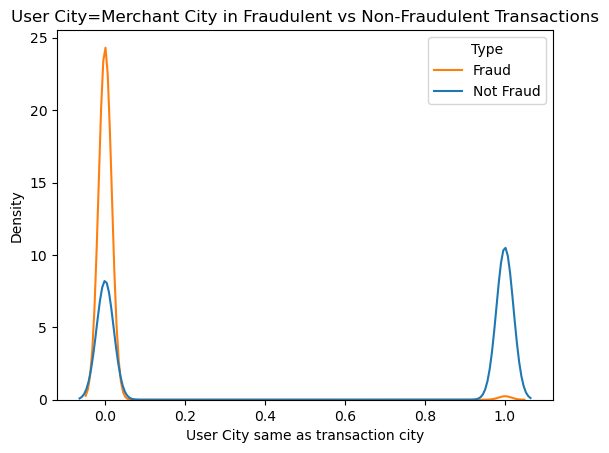

In [49]:
# merchant city =user city vs fraud
df_merged['City Same']= (df_merged['Merchant City_tr']==df_merged['City_u']).astype(int) #1 is True & 0 is False
#Plotting kde plot
ax=sns.kdeplot(x='City Same',data=df_merged, hue='Is Fraud?_tr', common_norm=False)
ax.set_xlabel('User City same as transaction city')
ax.set_ylabel('Density')
#plt.xticks(np.arange(-500,100,50))
plt.title('User City=Merchant City in Fraudulent vs Non-Fraudulent Transactions')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

### The above chart clearly depicts that fraud transactions are way more when the Cities don't match; we expect a similar trend for State Match as well

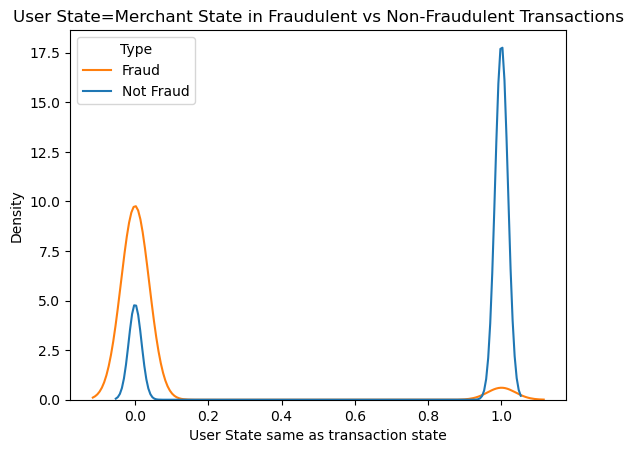

In [50]:
# merchant state =user state vs fraud
df_merged['State Same']= (df_merged['Merchant State_tr']==df_merged['State_u']).astype(int) #1 is True & 0 is False
#Plotting kde plot
ax=sns.kdeplot(x='State Same',data=df_merged, hue='Is Fraud?_tr', common_norm=False)
ax.set_xlabel('User State same as transaction state')
ax.set_ylabel('Density')
#plt.xticks(np.arange(-500,100,50))
plt.title('User State=Merchant State in Fraudulent vs Non-Fraudulent Transactions')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

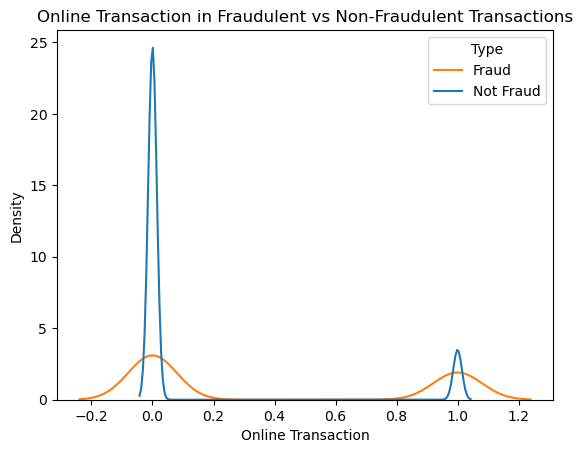

In [51]:
# online tr or not vs fraud
df_merged['Online transaction or not']= (df_merged['Use Chip_tr']=='Online Transaction').astype(int) #1 is True & 0 is False
#Plotting kde plot
ax=sns.kdeplot(x='Online transaction or not',data=df_merged, hue='Is Fraud?_tr', common_norm=False)
ax.set_xlabel('Online Transaction')
ax.set_ylabel('Density')
#plt.xticks(np.arange(-500,100,50))
plt.title('Online Transaction in Fraudulent vs Non-Fraudulent Transactions')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

In [83]:
# #Fraud vs Current Age_u,Gender_u
# plt.figure(figsize=(10,8))
# ax=sns.histplot(data=df_merged, x="Current Age_u", hue="Is Fraud?_tr", common_norm=False,stat='percent',multiple='dodge')
# ax.set_ylabel('Count')
# ax.set_xlabel('User Current Age')
# #plt.ylim(0, 60000) # for count
# #plt.ylim(0, 1.50)
# plt.title('Fraud vs Current Age')
# plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

# #Fraud vs Amt of transaction
# plt.figure(figsize=(10,8))
# ax=sns.histplot(data=df_merged, x="FICO Score_u", hue="Is Fraud?_tr", common_norm=False,stat='percent',bins=40,multiple='dodge')
# ax.set_ylabel('Percentage')
# ax.set_xlabel('FICO Score')
# #plt.ylim(0, 60000) # for count
# #plt.xticks(np.arange(-500,1200,100))
# plt.title('Fraud vs Transaction Amt')
# plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

#### the other user variables like Current Age, Gender, Total Debt, Yearly Income - Person, Fico score don't appear to have much bearing on outcome

In [52]:
df_merged.head(10)

User_tr  Card_tr  Year_tr  Month_tr  Day_tr Time_tr  Amount_tr  \
0        0        0     2016         1       3   10:48      66.48   
1        0        0     2016         1       4   06:43      40.02   
2        0        0     2016         1       7   09:30      54.11   
3        0        0     2016         1       7   16:03      89.48   
4        0        0     2016         1      10   06:38      29.15   
5        0        0     2016         1      13   06:37     120.00   
6        0        0     2016         1      13   13:52      56.87   
7        0        0     2016         1      15   10:56       1.44   
8        0        0     2016         1      18   16:57     102.90   
9        0        0     2016         1      19   06:58      41.61   

          Use Chip_tr     Merchant Name_tr Merchant City_tr Merchant State_tr  \
0    Chip Transaction -3345936507911876459         La Verne                CA   
1    Chip Transaction   -34551508091458520         La Verne                CA   
2    Chip Transaction  4055257078481058705         La Verne                CA   
3    Chip Transaction  3414527459579106770    Monterey Park                CA   
4    Chip Transaction -5475680618560174533    Monterey Park                CA   
5    Chip Transaction -4282466774399734331        Mira Loma                CA   
6    Chip Transaction  3527213246127876953         La Verne                CA   
7    Chip Transaction -7232193519160172381         La Verne                CA   
8  Online Transaction   208649686760524778           ONLINE              None   
9    Chip Transaction  4060646732831064559         La Verne                CA   

  Zip_tr  MCC_tr Errors?_tr Is Fraud?_tr transaction_date_tr  \
0  91750    7538       None           No          2016-01-03   
1  91750    5912       None           No          2016-01-04   
2  91750    7538       None           No          2016-01-07   
3  91754    5651       None           No          2016-01-07   
4  91755    5942       None           No          2016-01-10   
5  91752    4829       None           No          2016-01-13   
6  91750    5300       None           No          2016-01-13   
7  91750    7542       None           No          2016-01-15   
8    nan    5651       None           No          2016-01-18   
9  91750    5411       None           No          2016-01-19   

  transaction_time_tr  User_cc  CARD INDEX_cc Card Brand_cc Card Type_cc  \
0 2016-01-03 10:48:00        0              0          Visa        Debit   
1 2016-01-04 06:43:00        0              0          Visa        Debit   
2 2016-01-07 09:30:00        0              0          Visa        Debit   
3 2016-01-07 16:03:00        0              0          Visa        Debit   
4 2016-01-10 06:38:00        0              0          Visa        Debit   
5 2016-01-13 06:37:00        0              0          Visa        Debit   
6 2016-01-13 13:52:00        0              0          Visa        Debit   
7 2016-01-15 10:56:00        0              0          Visa        Debit   
8 2016-01-18 16:57:00        0              0          Visa        Debit   
9 2016-01-19 06:58:00        0              0          Visa        Debit   

     Card Number_cc Expires_cc  CVV_cc Has Chip_cc  Cards Issued_cc  \
0  4344676511950444 2022-12-01     623         YES                2   
1  4344676511950444 2022-12-01     623         YES                2   
2  4344676511950444 2022-12-01     623         YES                2   
3  4344676511950444 2022-12-01     623         YES                2   
4  4344676511950444 2022-12-01     623         YES                2   
5  4344676511950444 2022-12-01     623         YES                2   
6  4344676511950444 2022-12-01     623         YES                2   
7  4344676511950444 2022-12-01     623         YES                2   
8  4344676511950444 2022-12-01     623         YES                2   
9  4344676511950444 2022-12-01     623         YES                2   

   Credit Limit_cc Acct Ope

#### Looking at nan zipcode rows

In [53]:
#df_merged.head(10) ##zipcodes are of object dtype
nan_zip_tr=df_merged[df_merged['Zip_tr']=='nan']
nan_zip_tr.groupby(['Merchant City_tr','Merchant State_tr']).size().sort_values(ascending=False)
#nan_zip_tr['Merchant State_tr'].nunique()

Merchant City_tr  Merchant State_tr
Rome              Italy                6153
Cancun            Mexico               4683
Mexico City       Mexico               2557
Cabo San Lucas    Mexico               2326
Toronto           Canada               2022
                                       ... 
Podgorica         Montenegro              4
Paramaribo        Suriname                3
Managua           Nicaragua               3
Baku              Azerbaijan              2
Gaborone          Botswana                1
Length: 138, dtype: int64

In [54]:
print((nan_zip_tr[nan_zip_tr['Merchant City_tr']=='ONLINE']).shape,nan_zip_tr.shape)
## Hence 860k out of 907k transactions with nan zipcodes are online

(860764, 56) (907586, 56)


In [56]:
# Not working due to API limits
# def get_zip_code(row):
#     geolocator = Nominatim(user_agent="zipcode_generator")
#     location = geolocator.geocode(f"{row['Merchant City_tr']}, {row['Merchant State_tr']}")
#     return location.address.split(",")[-2].strip() if location else None

# # Apply the function to create a new column 
# df['Zip_tr_generated'] = df_merged.apply(get_zip_code,axis=1)

In [57]:
# df_merged['Zip_tr'] = df_merged['Zip_tr'].replace({'nan':'00000'})
# df_merged.head(10)

In [137]:
#conda install -c conda-forge pgeocode

In [55]:
def get_distance(x, y):
    usa_zipcodes = pgeocode.GeoDistance('us')
    distance_in_kms = usa_zipcodes.query_postal_code(x.values, y.values)
    return distance_in_kms
df_merged['Distance_zipcodes_km'] = get_distance(df_merged['Zip_tr'], df_merged['Zipcode_u'])

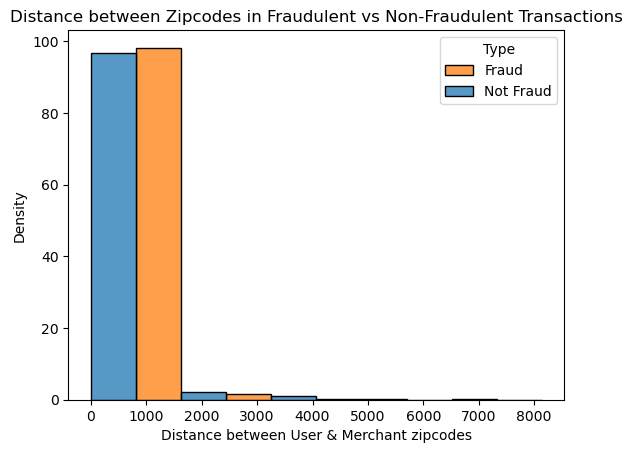

In [56]:
# zipcode distance vs fraud
#Plotting hist plot
ax=sns.histplot(x='Distance_zipcodes_km',data=df_merged, hue='Is Fraud?_tr', common_norm=False,stat='percent',bins=5,multiple='dodge')
ax.set_xlabel('Distance between User & Merchant zipcodes')
ax.set_ylabel('Density')
#plt.xticks(np.arange(-500,100,50))
plt.title('Distance between Zipcodes in Fraudulent vs Non-Fraudulent Transactions')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

In [57]:
def distance_available(row):
    if row['Distance_zipcodes_km'] >=0:
        val = 1
    else:
        val = 0
    return val

df_merged['Zipcode distance available']=df_merged.apply(distance_available, axis=1)

In [58]:
## assigning an outlier value for nan values
def impute_missing_distance(row):
    if row['Distance_zipcodes_km'] >=0:
        val = row['Distance_zipcodes_km']
    else:
        val = 20000
    return val

df_merged['Distance_zipcodes_km']=df_merged.apply(impute_missing_distance, axis=1)

In [59]:
df_merged.head(10)

User_tr  Card_tr  Year_tr  Month_tr  Day_tr Time_tr  Amount_tr  \
0        0        0     2016         1       3   10:48      66.48   
1        0        0     2016         1       4   06:43      40.02   
2        0        0     2016         1       7   09:30      54.11   
3        0        0     2016         1       7   16:03      89.48   
4        0        0     2016         1      10   06:38      29.15   
5        0        0     2016         1      13   06:37     120.00   
6        0        0     2016         1      13   13:52      56.87   
7        0        0     2016         1      15   10:56       1.44   
8        0        0     2016         1      18   16:57     102.90   
9        0        0     2016         1      19   06:58      41.61   

          Use Chip_tr     Merchant Name_tr Merchant City_tr Merchant State_tr  \
0    Chip Transaction -3345936507911876459         La Verne                CA   
1    Chip Transaction   -34551508091458520         La Verne                CA   
2    Chip Transaction  4055257078481058705         La Verne                CA   
3    Chip Transaction  3414527459579106770    Monterey Park                CA   
4    Chip Transaction -5475680618560174533    Monterey Park                CA   
5    Chip Transaction -4282466774399734331        Mira Loma                CA   
6    Chip Transaction  3527213246127876953         La Verne                CA   
7    Chip Transaction -7232193519160172381         La Verne                CA   
8  Online Transaction   208649686760524778           ONLINE              None   
9    Chip Transaction  4060646732831064559         La Verne                CA   

  Zip_tr  MCC_tr Errors?_tr Is Fraud?_tr transaction_date_tr  \
0  91750    7538       None           No          2016-01-03   
1  91750    5912       None           No          2016-01-04   
2  91750    7538       None           No          2016-01-07   
3  91754    5651       None           No          2016-01-07   
4  91755    5942       None           No          2016-01-10   
5  91752    4829       None           No          2016-01-13   
6  91750    5300       None           No          2016-01-13   
7  91750    7542       None           No          2016-01-15   
8    nan    5651       None           No          2016-01-18   
9  91750    5411       None           No          2016-01-19   

  transaction_time_tr  User_cc  CARD INDEX_cc Card Brand_cc Card Type_cc  \
0 2016-01-03 10:48:00        0              0          Visa        Debit   
1 2016-01-04 06:43:00        0              0          Visa        Debit   
2 2016-01-07 09:30:00        0              0          Visa        Debit   
3 2016-01-07 16:03:00        0              0          Visa        Debit   
4 2016-01-10 06:38:00        0              0          Visa        Debit   
5 2016-01-13 06:37:00        0              0          Visa        Debit   
6 2016-01-13 13:52:00        0              0          Visa        Debit   
7 2016-01-15 10:56:00        0              0          Visa        Debit   
8 2016-01-18 16:57:00        0              0          Visa        Debit   
9 2016-01-19 06:58:00        0              0          Visa        Debit   

     Card Number_cc Expires_cc  CVV_cc Has Chip_cc  Cards Issued_cc  \
0  4344676511950444 2022-12-01     623         YES                2   
1  4344676511950444 2022-12-01     623         YES                2   
2  4344676511950444 2022-12-01     623         YES                2   
3  4344676511950444 2022-12-01     623         YES                2   
4  4344676511950444 2022-12-01     623         YES                2   
5  4344676511950444 2022-12-01     623         YES                2   
6  4344676511950444 2022-12-01     623         YES                2   
7  4344676511950444 2022-12-01     623         YES                2   
8  4344676511950444 2022-12-01     623         YES                2   
9  4344676511950444 2022-12-01     623         YES                2   

   Credit Limit_cc Acct Ope

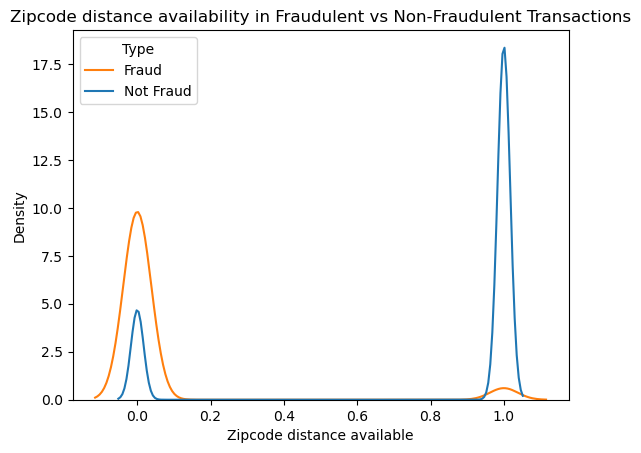

In [60]:
#Plotting kde plot
ax=sns.kdeplot(x='Zipcode distance available',data=df_merged, hue='Is Fraud?_tr', common_norm=False)
ax.set_xlabel('Zipcode distance available')
ax.set_ylabel('Density')
#plt.xticks(np.arange(-500,100,50))
plt.title('Zipcode distance availability in Fraudulent vs Non-Fraudulent Transactions')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])
#looks very similar to kde plot of Merchant state

#### As seen above distance between zipcodes is not conclusive of fraud or non fraud transactions

In [66]:
#df_merged.head(10)

### Variables to be considered for Input dataset as they seem to have an impact on fraud transaction : 
#### 'day_name', 'hour', 'Month_tr', 'Year_tr', 'Accntage_asof_transaction_days', 'Card Brand_cc','Card Type_cc',  'Credit Limit_cc', 'Amount_tr', 'Year PIN last Changed_cc', 'City Same', 'State Same', 'Online transaction or not', 'Distance_zipcodes_km', '

#### Remove : 'Has Chip_cc', 'Acct Open Date_cc','Expires_cc','Credit Limit_cc', 'Amount_tr'

In [61]:
df_postEDA=df_merged.copy()

In [62]:
df_merged=df_postEDA.copy()

In [63]:
df_merged.dtypes
#df_merged['MCC_tr'].head()

User_tr                                        int64
Card_tr                                        int64
Year_tr                                        int64
Month_tr                                       int64
Day_tr                                         int64
Time_tr                                       object
Amount_tr                                    float64
Use Chip_tr                                   object
Merchant Name_tr                               int64
Merchant City_tr                              object
Merchant State_tr                             object
Zip_tr                                        object
MCC_tr                                         int64
Errors?_tr                                    object
Is Fraud?_tr                                  object
transaction_date_tr                   datetime64[ns]
transaction_time_tr                   datetime64[ns]
User_cc                                        int64
CARD INDEX_cc                                 

In [64]:
df_merged.describe()

User_tr       Card_tr       Year_tr      Month_tr        Day_tr  \
count  6.877837e+06  6.877837e+06  6.877837e+06  6.877837e+06  6.877837e+06   
mean   1.006567e+03  1.279854e+00  2.017503e+03  6.528485e+00  1.572455e+01   
std    5.703017e+02  1.367238e+00  1.117242e+00  3.446495e+00  8.796571e+00   
min    0.000000e+00  0.000000e+00  2.016000e+03  1.000000e+00  1.000000e+00   
25%    5.170000e+02  0.000000e+00  2.017000e+03  4.000000e+00  8.000000e+00   
50%    1.011000e+03  1.000000e+00  2.018000e+03  7.000000e+00  1.600000e+01   
75%    1.487000e+03  2.000000e+00  2.019000e+03  1.000000e+01  2.300000e+01   
max    1.999000e+03  8.000000e+00  2.019000e+03  1.200000e+01  3.100000e+01   

          Amount_tr  Merchant Name_tr        MCC_tr       User_cc  \
count  6.877837e+06      6.877837e+06  6.877837e+06  6.877837e+06   
mean   4.287884e+01     -4.896856e+17  5.558895e+03  1.006567e+03   
std    8.063070e+01      4.765167e+18  8.811638e+02  5.703017e+02   
min   -5.000000e+02     -9.222899e+18  1.711000e+03  0.000000e+00   
25%    9.030000e+00     -4.530601e+18  5.300000e+03  5.170000e+02   
50%    2.923000e+01     -8.312016e+17  5.499000e+03  1.011000e+03   
75%    6.300000e+01      3.189517e+18  5.812000e+03  1.487000e+03   
max    6.613440e+03      9.222877e+18  9.402000e+03  1.999000e+03   

       CARD INDEX_cc  Card Number_cc        CVV_cc  Cards Issued_cc  \
count   6.877837e+06    6.877837e+06  6.877837e+06     6.877837e+06   
mean    1.279854e+00    4.842029e+15  4.940814e+02     1.519921e+00   
std     1.367238e+00    1.286209e+15  2.898004e+02     5.167412e-01   
min     0.000000e+00    3.006098e+14  0.000000e+00     1.000000e+00   
25%     0.000000e+00    4.499975e+15  2.410000e+02     1.000000e+00   
50%     1.000000e+00    5.115906e+15  4.960000e+02     2.000000e+00   
75%     2.000000e+00    5.582577e+15  7.410000e+02     2.000000e+00   
max     8.000000e+00    6.994498e+15  9.990000e+02     3.000000e+00   

       Credit Limit_cc  Year PIN last Changed_cc       index_u  Current Age_u  \
count     6.877837e+06              6.877837e+06  6.877837e+06   6.877837e+06   
mean      1.542318e+04              2.011757e+03  1.006567e+03   5.215942e+01   
std       1.198659e+04              3.014304e+00  5.703017e+02   1.621340e+01   
min       0.000000e+00              2.002000e+03  0.000000e+00   1.800000e+01   
25%       7.800000e+03              2.010000e+03  5.170000e+02   4.000000e+01   
50%       1.346000e+04              2.011000e+03  1.011000e+03   5.000000e+01   
75%       2.076500e+04              2.014000e+03  1.487000e+03   6.200000e+01   
max       1.413910e+05              2.020000e+03  1.999000e+03   1.010000e+02   

       Retirement Age_u  Birth Year_u  Birth Month_u   Apartment_u  \
count      6.877837e+06  6.877837e+06   6.877837e+06  1.878076e+06   
mean       6.638086e+01  1.967023e+03   6.537452e+00  6.664129e+02   
std        3.574075e+00  1.620578e+01   3.568148e+00  1.836120e+03   
min        5.000000e+01  1.918000e+03   1.000000e+00  1.000000e+00   
25%        6.500000e+01  1.957000e+03   3.000000e+00  5.000000e+00   
50%        6.600000e+01  1.969000e+03   7.000000e+00  1.000000e+01   
75%        6.800000e+01  1.979000e+03   1.000000e+01  9.700000e+01   
max        7.900000e+01  2.002000e+03   1.200000e+01  9.940000e+03   

         Latitude_u   Longitude_u  Per Capita Income - Zipcode_u  \
count  6.877837e+06  6.877837e+06                   6.877837e+06   
mean   3.739319e+01 -9.135936e+01                   2.391182e+04   
std    5.077668e+00  1.623014e+01                   1.156658e+04   
min    2.130000e+01 -1.594100e+02                   0.000000e+00   
25%    3.389000e+01 -9.734000e+01                   1.707600e+04   
50%    3.841000e+01 -8.628000e+01                   2.117800e+04   
75%    4.109000e+01 -7.999000e+01                   2.754600e+04   
max    6.120000e+01 -6.867000e+01                   1.631450e+05   

       Yearly Income - Person_u  Total Debt_u  FICO Score_u  \
c

In [65]:
df_merged.select_dtypes(include=['object', 'category']).columns

Index(['Time_tr', 'Use Chip_tr', 'Merchant City_tr', 'Merchant State_tr',
       'Zip_tr', 'Errors?_tr', 'Is Fraud?_tr', 'Card Brand_cc', 'Card Type_cc',
       'Has Chip_cc', 'Card on Dark Web_cc', 'Person_u', 'Gender_u',
       'Address_u', 'City_u', 'State_u', 'Zipcode_u'],
      dtype='object')

### ************************************************************************************************************************************
### 3.0🔰 EDA + pre-processing
### ************************************************************************************************************************************
### Now we will clean the dataset : 1. have only a set of columns (combination of numerical + low cardinality categorical variables) so that one hot encoding / Binary Encoder can be used 2. Standardize dataset using StandardScaler( ) 3. Use BinaryEncoder ( ) 3. Explore strategies of splitting into train & test series

#### NOT remove categorical columns with missing values (Merchant State_tr,Zip_tr) as those canbe replaced with a placeholder value & label encoded; this way we are not losing information
#### we can focus more on other  info so remove unnecessary / redundant columns

#### 3.1🔰 Dropping Redundant columns

In [66]:
df_merged.drop(['Time_tr','index_u','Person_u'],axis=1,inplace=True)
df_merged.select_dtypes(include=['object', 'category']).columns

Index(['Use Chip_tr', 'Merchant City_tr', 'Merchant State_tr', 'Zip_tr',
       'Errors?_tr', 'Is Fraud?_tr', 'Card Brand_cc', 'Card Type_cc',
       'Has Chip_cc', 'Card on Dark Web_cc', 'Gender_u', 'Address_u', 'City_u',
       'State_u', 'Zipcode_u'],
      dtype='object')

In [67]:
df_merged.drop(['User_cc', 'CARD INDEX_cc','transaction_date_tr', 'transaction_time_tr','CVV_cc','day_name',
                'Expires_cc','Acct Open Date_cc','Retirement Age_u', 'Birth Year_u','Address_u','Apartment_u'],axis=1,inplace=True)

In [75]:
df_merged['Card Number_cc'].astype(str).str[0].unique()
## tells us that we cannot add any categories/ industries as  feature engineering as it corresponds to card brands

KeyError: 'Card Number_cc'

In [71]:
df_merged.drop(['Card Number_cc','Total Debt_u', 'FICO Score_u','Latitude_u', 'Longitude_u','Has Chip_cc','Card on Dark Web_cc','Birth Month_u','City_u', 'State_u', 'Zipcode_u','Zip_tr','Yearly Income - Person_u','Credit Limit_cc'],axis=1,inplace=True) 

In [72]:
df_merged.columns

Index(['User_tr', 'Card_tr', 'Year_tr', 'Month_tr', 'Day_tr', 'Amount_tr',
       'Use Chip_tr', 'Merchant Name_tr', 'Merchant City_tr',
       'Merchant State_tr', 'MCC_tr', 'Errors?_tr', 'Is Fraud?_tr',
       'Card Brand_cc', 'Card Type_cc', 'Cards Issued_cc',
       'Year PIN last Changed_cc', 'Current Age_u', 'Gender_u',
       'Per Capita Income - Zipcode_u', 'Num Credit Cards_u', 'hour',
       'Accntage_asof_transaction_days', 'DaysToExpiry_asof_transaction_days',
       'City Same', 'State Same', 'Online transaction or not',
       'Distance_zipcodes_km', 'Zipcode distance available'],
      dtype='object')

In [73]:
df_merged.head(10)

User_tr  Card_tr  Year_tr  Month_tr  Day_tr  Amount_tr         Use Chip_tr  \
0        0        0     2016         1       3      66.48    Chip Transaction   
1        0        0     2016         1       4      40.02    Chip Transaction   
2        0        0     2016         1       7      54.11    Chip Transaction   
3        0        0     2016         1       7      89.48    Chip Transaction   
4        0        0     2016         1      10      29.15    Chip Transaction   
5        0        0     2016         1      13     120.00    Chip Transaction   
6        0        0     2016         1      13      56.87    Chip Transaction   
7        0        0     2016         1      15       1.44    Chip Transaction   
8        0        0     2016         1      18     102.90  Online Transaction   
9        0        0     2016         1      19      41.61    Chip Transaction   

      Merchant Name_tr Merchant City_tr Merchant State_tr  MCC_tr Errors?_tr  \
0 -3345936507911876459         La Verne                CA    7538       None   
1   -34551508091458520         La Verne                CA    5912       None   
2  4055257078481058705         La Verne                CA    7538       None   
3  3414527459579106770    Monterey Park                CA    5651       None   
4 -5475680618560174533    Monterey Park                CA    5942       None   
5 -4282466774399734331        Mira Loma                CA    4829       None   
6  3527213246127876953         La Verne                CA    5300       None   
7 -7232193519160172381         La Verne                CA    7542       None   
8   208649686760524778           ONLINE              None    5651       None   
9  4060646732831064559         La Verne                CA    5411       None   

  Is Fraud?_tr Card Brand_cc Card Type_cc  Cards Issued_cc  \
0           No          Visa        Debit                2   
1           No          Visa        Debit                2   
2           No          Visa        Debit                2   
3           No          Visa        Debit                2   
4           No          Visa        Debit                2   
5           No          Visa        Debit                2   
6           No          Visa        Debit                2   
7           No          Visa        Debit                2   
8           No          Visa        Debit                2   
9           No          Visa        Debit                2   

   Year PIN last Changed_cc  Current Age_u Gender_u  \
0                      2008             53   Female   
1                      2008             53   Female   
2                      2008             53   Female   
3                      2008             53   Female   
4                      2008             53   Female   
5                      2008             53   Female   
6                      2008             53   Female   
7                      2008             53   Female   
8                      2008             53   Female   
9                      2008             53   Female   

   Per Capita Income - Zipcode_u  Num Credit Cards_u  hour  \
0                          29278                   5    10   
1                          29278                   5     6   
2                          29278                   5     9   
3                          29278                   5    16   
4                          29278                   5     6   
5                          29278                   5     6   
6                          29278                   5    13   
7                          29278                   5    10   
8                          29278                   5    16   
9                          29278                   5     6   

   Accntage_asof_transaction_days  DaysToExpiry_asof_transaction_days  \
0                            4872                                2524   
1                            4873                                2523   
2                            4876      

In [74]:
print(df_merged.shape)

(6877837, 29)


In [76]:
df_merged_afterclean=df_merged.copy()

In [77]:
df_merged=df_merged_afterclean.copy()

#### 3.2🔰 Binary Encoding + Label Encoding (high. cardinality columns)

In [78]:
df_merged.select_dtypes(include=['int64', 'float64']).columns

Index(['User_tr', 'Card_tr', 'Year_tr', 'Month_tr', 'Day_tr', 'Amount_tr',
       'Merchant Name_tr', 'MCC_tr', 'Cards Issued_cc',
       'Year PIN last Changed_cc', 'Current Age_u',
       'Per Capita Income - Zipcode_u', 'Num Credit Cards_u', 'hour',
       'Accntage_asof_transaction_days', 'DaysToExpiry_asof_transaction_days',
       'City Same', 'State Same', 'Online transaction or not',
       'Distance_zipcodes_km', 'Zipcode distance available'],
      dtype='object')

In [79]:
df_merged.select_dtypes(include=['object', 'category']).columns

Index(['Use Chip_tr', 'Merchant City_tr', 'Merchant State_tr', 'Errors?_tr',
       'Is Fraud?_tr', 'Card Brand_cc', 'Card Type_cc', 'Gender_u'],
      dtype='object')

In [80]:
cat_cols=['Use Chip_tr', 'Card Brand_cc', 'Card Type_cc','Gender_u'] #excluding 'Is Fraud?_tr'

In [81]:
def transform_cat_BE(df, cols_to_cat=None):
    '''Applies binary encoding to all categorical columns in df.
    Returns new df of encoded columns
    '''
    X = df[cols_to_cat]
    encoder = ce.binary.BinaryEncoder(return_df=True)
    enc_df = encoder.fit_transform(X)
    return enc_df

In [82]:
df_merged.shape

(6877837, 29)

In [83]:
encoded_df=transform_cat_BE(df_merged,cat_cols)

In [84]:
df_merged = pd.concat([df_merged, encoded_df], axis=1)
df_merged.drop(cat_cols, axis=1, inplace=True)
df_merged.head()

User_tr  Card_tr  Year_tr  Month_tr  Day_tr  Amount_tr  \
0        0        0     2016         1       3      66.48   
1        0        0     2016         1       4      40.02   
2        0        0     2016         1       7      54.11   
3        0        0     2016         1       7      89.48   
4        0        0     2016         1      10      29.15   

      Merchant Name_tr Merchant City_tr Merchant State_tr  MCC_tr Errors?_tr  \
0 -3345936507911876459         La Verne                CA    7538       None   
1   -34551508091458520         La Verne                CA    5912       None   
2  4055257078481058705         La Verne                CA    7538       None   
3  3414527459579106770    Monterey Park                CA    5651       None   
4 -5475680618560174533    Monterey Park                CA    5942       None   

  Is Fraud?_tr  Cards Issued_cc  Year PIN last Changed_cc  Current Age_u  \
0           No                2                      2008             53   
1           No                2                      2008             53   
2           No                2                      2008             53   
3           No                2                      2008             53   
4           No                2                      2008             53   

   Per Capita Income - Zipcode_u  Num Credit Cards_u  hour  \
0                          29278                   5    10   
1                          29278                   5     6   
2                          29278                   5     9   
3                          29278                   5    16   
4                          29278                   5     6   

   Accntage_asof_transaction_days  DaysToExpiry_asof_transaction_days  \
0                            4872                                2524   
1                            4873                                2523   
2                            4876                                2520   
3                            4876                                2520   
4                            4879                                2517   

   City Same  State Same  Online transaction or not  Distance_zipcodes_km  \
0          1           1                          0              0.000000   
1          1           1                          0              0.000000   
2          1           1                          0              0.000000   
3          0           1                          0             33.540588   
4          0           1                          0             32.586123   

   Zipcode distance available  Use Chip_tr_0  Use Chip_tr_1  Card Brand_cc_0  \
0                           1              0              1                0   
1                           1              0              1                0   
2                           1              0              1                0   
3                           1              0              1                0   
4                           1              0              1                0   

   Card Brand_cc_1  Card Brand_cc_2  Card Type_cc_0  Card Type_cc_1  \
0                0                1               0               1   
1                0                1               0               1   
2                0                1               0               1   
3                0                1               0               1   
4                0                1               0               1   

   Gender_u_0  Gender_u_1  
0           0           1  
1           0           1  
2           0           1  
3           0           1  
4           0           1

In [85]:
df_merged["Errors?_tr"].unique()

array([None, 'Insufficient Balance', 'Bad PIN', 'Technical Glitch',
       'Bad Expiration', 'Bad Card Number', 'Bad CVV',
       'Bad Card Number,Insufficient Balance', 'Bad Card Number,Bad CVV',
       'Insufficient Balance,Technical Glitch', 'Bad Zipcode',
       'Bad PIN,Insufficient Balance', 'Bad PIN,Technical Glitch',
       'Bad Card Number,Bad Expiration', 'Bad CVV,Insufficient Balance',
       'Bad Expiration,Insufficient Balance', 'Bad Expiration,Bad CVV',
       'Bad Expiration,Technical Glitch', 'Bad Zipcode,Technical Glitch',
       'Bad Zipcode,Insufficient Balance', 'Bad CVV,Technical Glitch',
       'Bad Card Number,Technical Glitch'], dtype=object)

#### 3.3🔰 Label Encoding High cardinality columns like ' Merchant City ' & 'Errors?' , 'Merchant State', 'Zip'

In [86]:
#Columns for label encoding : ['Merchant City_tr', 'Errors?_tr']
df_merged["Merchant City_tr"]=LabelEncoder().fit_transform(df_merged["Merchant City_tr"])
#df_merged["City_u"]=LabelEncoder().fit_transform(df_merged["City_u"])
df_merged["Errors?_tr"]=LabelEncoder().fit_transform(df_merged["Errors?_tr"])
df_merged.head(3)

User_tr  Card_tr  Year_tr  Month_tr  Day_tr  Amount_tr  \
0        0        0     2016         1       3      66.48   
1        0        0     2016         1       4      40.02   
2        0        0     2016         1       7      54.11   

      Merchant Name_tr  Merchant City_tr Merchant State_tr  MCC_tr  \
0 -3345936507911876459              5203                CA    7538   
1   -34551508091458520              5203                CA    5912   
2  4055257078481058705              5203                CA    7538   

   Errors?_tr Is Fraud?_tr  Cards Issued_cc  Year PIN last Changed_cc  \
0          21           No                2                      2008   
1          21           No                2                      2008   
2          21           No                2                      2008   

   Current Age_u  Per Capita Income - Zipcode_u  Num Credit Cards_u  hour  \
0             53                          29278                   5    10   
1             53                          29278                   5     6   
2             53                          29278                   5     9   

   Accntage_asof_transaction_days  DaysToExpiry_asof_transaction_days  \
0                            4872                                2524   
1                            4873                                2523   
2                            4876                                2520   

   City Same  State Same  Online transaction or not  Distance_zipcodes_km  \
0          1           1                          0                   0.0   
1          1           1                          0                   0.0   
2          1           1                          0                   0.0   

   Zipcode distance available  Use Chip_tr_0  Use Chip_tr_1  Card Brand_cc_0  \
0                           1              0              1                0   
1                           1              0              1                0   
2                           1              0              1                0   

   Card Brand_cc_1  Card Brand_cc_2  Card Type_cc_0  Card Type_cc_1  \
0                0                1               0               1   
1                0                1               0               1   
2                0                1               0               1   

   Gender_u_0  Gender_u_1  
0           0           1  
1           0           1  
2           0           1

In [87]:
df_merged['Merchant State_tr'].fillna('NA', inplace=True)
# df_merged['Merchant State_tr'] = df_merged['Merchant State_tr'].astype('category')
#df_merged['Zip_tr'].fillna(0, inplace=True)
df_merged["Merchant State_tr"]=LabelEncoder().fit_transform(df_merged["Merchant State_tr"])
#df_merged["State_u"]=LabelEncoder().fit_transform(df_merged["State_u"])
#df_merged["Zip_tr"]=LabelEncoder().fit_transform(df_merged["Zip_tr"])
#df_merged["Zipcode_u"]=LabelEncoder().fit_transform(df_merged["Zipcode_u"])
df_merged.head(3)

User_tr  Card_tr  Year_tr  Month_tr  Day_tr  Amount_tr  \
0        0        0     2016         1       3      66.48   
1        0        0     2016         1       4      40.02   
2        0        0     2016         1       7      54.11   

      Merchant Name_tr  Merchant City_tr  Merchant State_tr  MCC_tr  \
0 -3345936507911876459              5203                 20    7538   
1   -34551508091458520              5203                 20    5912   
2  4055257078481058705              5203                 20    7538   

   Errors?_tr Is Fraud?_tr  Cards Issued_cc  Year PIN last Changed_cc  \
0          21           No                2                      2008   
1          21           No                2                      2008   
2          21           No                2                      2008   

   Current Age_u  Per Capita Income - Zipcode_u  Num Credit Cards_u  hour  \
0             53                          29278                   5    10   
1             53                          29278                   5     6   
2             53                          29278                   5     9   

   Accntage_asof_transaction_days  DaysToExpiry_asof_transaction_days  \
0                            4872                                2524   
1                            4873                                2523   
2                            4876                                2520   

   City Same  State Same  Online transaction or not  Distance_zipcodes_km  \
0          1           1                          0                   0.0   
1          1           1                          0                   0.0   
2          1           1                          0                   0.0   

   Zipcode distance available  Use Chip_tr_0  Use Chip_tr_1  Card Brand_cc_0  \
0                           1              0              1                0   
1                           1              0              1                0   
2                           1              0              1                0   

   Card Brand_cc_1  Card Brand_cc_2  Card Type_cc_0  Card Type_cc_1  \
0                0                1               0               1   
1                0                1               0               1   
2                0                1               0               1   

   Gender_u_0  Gender_u_1  
0           0           1  
1           0           1  
2           0           1

In [88]:
df_encoded=df_merged.copy()

In [89]:
df_merged=df_encoded.copy()

In [90]:
df_merged.describe()

User_tr       Card_tr       Year_tr      Month_tr        Day_tr  \
count  6.877837e+06  6.877837e+06  6.877837e+06  6.877837e+06  6.877837e+06   
mean   1.006567e+03  1.279854e+00  2.017503e+03  6.528485e+00  1.572455e+01   
std    5.703017e+02  1.367238e+00  1.117242e+00  3.446495e+00  8.796571e+00   
min    0.000000e+00  0.000000e+00  2.016000e+03  1.000000e+00  1.000000e+00   
25%    5.170000e+02  0.000000e+00  2.017000e+03  4.000000e+00  8.000000e+00   
50%    1.011000e+03  1.000000e+00  2.018000e+03  7.000000e+00  1.600000e+01   
75%    1.487000e+03  2.000000e+00  2.019000e+03  1.000000e+01  2.300000e+01   
max    1.999000e+03  8.000000e+00  2.019000e+03  1.200000e+01  3.100000e+01   

          Amount_tr  Merchant Name_tr  Merchant City_tr  Merchant State_tr  \
count  6.877837e+06      6.877837e+06      6.877837e+06       6.877837e+06   
mean   4.287884e+01     -4.896856e+17      5.667954e+03       8.590876e+01   
std    8.063070e+01      4.765167e+18      3.057148e+03       4.476249e+01   
min   -5.000000e+02     -9.222899e+18      0.000000e+00       0.000000e+00   
25%    9.030000e+00     -4.530601e+18      3.071000e+03       4.300000e+01   
50%    2.923000e+01     -8.312016e+17      6.290000e+03       9.900000e+01   
75%    6.300000e+01      3.189517e+18      7.742000e+03       1.140000e+02   
max    6.613440e+03      9.222877e+18      1.121700e+04       1.680000e+02   

             MCC_tr    Errors?_tr  Cards Issued_cc  Year PIN last Changed_cc  \
count  6.877837e+06  6.877837e+06     6.877837e+06              6.877837e+06   
mean   5.558895e+03  2.091836e+01     1.519921e+00              2.011757e+03   
std    8.811638e+02  8.874110e-01     5.167412e-01              3.014304e+00   
min    1.711000e+03  0.000000e+00     1.000000e+00              2.002000e+03   
25%    5.300000e+03  2.100000e+01     1.000000e+00              2.010000e+03   
50%    5.499000e+03  2.100000e+01     2.000000e+00              2.011000e+03   
75%    5.812000e+03  2.100000e+01     2.000000e+00              2.014000e+03   
max    9.402000e+03  2.100000e+01     3.000000e+00              2.020000e+03   

       Current Age_u  Per Capita Income - Zipcode_u  Num Credit Cards_u  \
count   6.877837e+06                   6.877837e+06        6.877837e+06   
mean    5.215942e+01                   2.391182e+04        3.569649e+00   
std     1.621340e+01                   1.156658e+04        1.615466e+00   
min     1.800000e+01                   0.000000e+00        1.000000e+00   
25%     4.000000e+01                   1.707600e+04        2.000000e+00   
50%     5.000000e+01                   2.117800e+04        4.000000e+00   
75%     6.200000e+01                   2.754600e+04        5.000000e+00   
max     1.010000e+02                   1.631450e+05        9.000000e+00   

               hour  Accntage_asof_transaction_days  \
count  6.877837e+06                    6.877837e+06   
mean   1.239003e+01                    3.381906e+03   
std    5.077223e+00                    1.676044e+03   
min    0.000000e+00                   -5.550000e+02   
25%    9.000000e+00                    2.272000e+03   
50%    1.200000e+01                    3.303000e+03   
75%    1.600000e+01                    4.459000e+03   
max    2.300000e+01                    1.059000e+04   

       DaysToExpiry_asof_transaction_days     City Same    State Same  \
count                        6.877837e+06  6.877837e+06  6.877837e+06   
mean                         1.533473e+03  5.606769e-01  7.876296e-01   
std                          7.222059e+02  4.963047e-01  4.089856e-01   
min                         -3.800000e+01  0.000000e+00  0.000000e+00   
25%                          9.990000e+02  0.000000e+00  1.000000e+00   
50%                          1.540000e+03  1.000000e+00  1.000000e+00   
75%                          2.063000e+03  1.000000e+00  1.000000e+00   
max                          3.257000e+03  1.000000e+00  1.000000e+00   

       Online transaction or not  Distance_zip

In [94]:
num_cols=['Card_tr','Year_tr', 'Month_tr', 'Day_tr', 'Amount_tr','Merchant Name_tr', 'MCC_tr', 'Cards Issued_cc'
          ,'Year PIN last Changed_cc', 'hour','Merchant City_tr','Accntage_asof_transaction_days'
          , 'DaysToExpiry_asof_transaction_days','Merchant State_tr','Errors?_tr','Cards Issued_cc'
          ,'Current Age_u','Per Capita Income - Zipcode_u', 'Num Credit Cards_u','Distance_zipcodes_km']

In [92]:
def transform_num(df):
    # Scale the Numeric columns
    scaler = StandardScaler()
    for col in num_cols:
        df[col] = scaler.fit_transform(df[[col]])
    
    return df

In [95]:
transform_num(df_merged)
df_merged.head()

User_tr   Card_tr  Year_tr  Month_tr    Day_tr  Amount_tr  \
0        0 -0.936087 -1.34541 -1.604089 -1.446536   0.292707   
1        0 -0.936087 -1.34541 -1.604089 -1.332855  -0.035456   
2        0 -0.936087 -1.34541 -1.604089 -0.991813   0.139291   
3        0 -0.936087 -1.34541 -1.604089 -0.991813   0.577958   
4        0 -0.936087 -1.34541 -1.604089 -0.650771  -0.170268   

   Merchant Name_tr  Merchant City_tr  Merchant State_tr    MCC_tr  \
0         -0.599402         -0.152088          -1.472411  2.246012   
1          0.095513         -0.152088          -1.472411  0.400725   
2          0.953785         -0.152088          -1.472411  2.246012   
3          0.819324          0.271510          -1.472411  0.104526   
4         -1.046342          0.271510          -1.472411  0.434771   

   Errors?_tr Is Fraud?_tr  Cards Issued_cc  Year PIN last Changed_cc  \
0    0.091995           No         0.929051                 -1.246494   
1    0.091995           No         0.929051                 -1.246494   
2    0.091995           No         0.929051                 -1.246494   
3    0.091995           No         0.929051                 -1.246494   
4    0.091995           No         0.929051                 -1.246494   

   Current Age_u  Per Capita Income - Zipcode_u  Num Credit Cards_u      hour  \
0       0.051845                       0.463939            0.885411 -0.470736   
1       0.051845                       0.463939            0.885411 -1.258569   
2       0.051845                       0.463939            0.885411 -0.667694   
3       0.051845                       0.463939            0.885411  0.711012   
4       0.051845                       0.463939            0.885411 -1.258569   

   Accntage_asof_transaction_days  DaysToExpiry_asof_transaction_days  \
0                        0.889055                            1.371530   
1                        0.889651                            1.370146   
2                        0.891441                            1.365992   
3                        0.891441                            1.365992   
4                        0.893231                            1.361838   

   City Same  State Same  Online transaction or not  Distance_zipcodes_km  \
0          1           1                          0             -0.523994   
1          1           1                          0             -0.523994   
2          1           1                          0             -0.523994   
3          0           1                          0             -0.519803   
4          0           1                          0             -0.519923   

   Zipcode distance available  Use Chip_tr_0  Use Chip_tr_1  Card Brand_cc_0  \
0                           1              0              1                0   
1                           1              0              1                0   
2                           1              0              1                0   
3                           1              0              1                0   
4                           1              0              1                0   

   Card Brand_cc_1  Card Brand_cc_2  Card Type_cc_0  Card Type_cc_1  \
0                0                1               0               1   
1                0                1               0               1   
2                0                1               0               1   
3                0                1               0               1   
4                0                1               0               1   

   Gender_u_0  Gender_u_1  
0           0           1  
1           0           1  
2           0           1  
3           0           1  
4           0           1

In [96]:
df_merged_all3df=df_merged.copy()

In [97]:
df_merged=df_merged_all3df.copy()

In [98]:
## remove the non scaled columns
df_merged.drop(['User_tr'], axis=1,inplace=True)
df_merged.shape

(6877837, 33)

In [99]:
df_merged.dtypes

Card_tr                               float64
Year_tr                               float64
Month_tr                              float64
Day_tr                                float64
Amount_tr                             float64
Merchant Name_tr                      float64
Merchant City_tr                      float64
Merchant State_tr                     float64
MCC_tr                                float64
Errors?_tr                            float64
Is Fraud?_tr                           object
Cards Issued_cc                       float64
Year PIN last Changed_cc              float64
Current Age_u                         float64
Per Capita Income - Zipcode_u         float64
Num Credit Cards_u                    float64
hour                                  float64
Accntage_asof_transaction_days        float64
DaysToExpiry_asof_transaction_days    float64
City Same                               int64
State Same                              int64
Online transaction or not         

### ************************************************************************************************************************************
### 4.0🔰 Start of  train-test splitting & modeling  
### ************************************************************************************************************************************

### Ways to split into training & testing datasets : 1. Stratified sampling, 2. Rndom Undersampling technique 3. SMOTE (Synthetic Minority Oversampling Technique) method to resample the training dataset so as to train on more balanced data for better results

In [100]:
## dataset 1 : using only transaction + card details
## dataset 2 : using transaction + card + customer details
input_df1= df_merged.copy()

In [101]:
input_df1_fraud=input_df1[input_df1['Is Fraud?_tr'] == 'Yes']
input_df1_nonfraud=input_df1[input_df1['Is Fraud?_tr'] == 'No']
print(input_df1_fraud.shape, input_df1_nonfraud.shape)

(8412, 33) (6869425, 33)


### Drawing a sample of Dataset ~5% from fraud & non fraud data

In [102]:
nonfraud_subsample= input_df1_nonfraud.sample(frac=0.05, replace=True, random_state=11)
fraud_subsample= input_df1_fraud.sample(frac=0.05, replace=True, random_state=11)
subsample = pd.concat([fraud_subsample, nonfraud_subsample])

In [103]:
subsample.groupby(['Is Fraud?_tr']).size()

Is Fraud?_tr
No     343471
Yes       421
dtype: int64

In [104]:
##having a input dataset with 0 & 1 as target column (mandatoryfor some models)
subsample2=subsample.copy()
subsample2['Is Fraud?_tr'].replace(to_replace=['No', 'Yes'], value=[0, 1],inplace=True)
subsample2.groupby(['Is Fraud?_tr']).size()

Is Fraud?_tr
0    343471
1       421
dtype: int64

In [105]:
subsample2.head()

Card_tr   Year_tr  Month_tr    Day_tr  Amount_tr  Merchant Name_tr  \
3190934  1.989519  0.444713  0.426960  1.736523  -0.186887          0.051311   
4259584  0.526716 -1.345410  0.136810  1.168120  -0.401942          1.390275   
5826984 -0.204686  1.339775 -1.023789 -0.196049  -0.499919          0.735937   
3403824 -0.204686  1.339775 -0.153340  0.713397   2.531556         -1.190327   
1118809 -0.204686  0.444713  1.007260  1.736523  -0.530429          0.528258   

         Merchant City_tr  Merchant State_tr    MCC_tr  Errors?_tr  \
3190934          0.953845          -0.467105 -0.281327    0.091995   
4259584          0.498192           0.292460  4.361397    0.091995   
5826984          0.953845          -0.467105  0.410939    0.091995   
3403824          0.953845          -0.467105 -2.462534    0.091995   
1118809          0.953845          -0.467105 -0.020309  -10.049867   

         Is Fraud?_tr  Cards Issued_cc  Year PIN last Changed_cc  \
3190934             1         0.929051                 -0.582991   
4259584             1         0.929051                  1.075767   
5826984             1         0.929051                 -0.251239   
3403824             1         0.929051                  0.080513   
1118809             1        -1.006154                 -1.578245   

         Current Age_u  Per Capita Income - Zipcode_u  Num Credit Cards_u  \
3190934      -0.256542                       1.142013            0.885411   
4259584       0.977005                      -0.109611            0.266395   
5826984       2.025521                      -0.837570            0.266395   
3403824       0.360232                       0.108432            1.504428   
1118809       0.051845                       0.216847            0.885411   

             hour  Accntage_asof_transaction_days  \
3190934  0.514054                       -0.329291   
4259584  1.695803                        0.230957   
5826984 -0.273778                       -0.412821   
3403824  1.301887                       -0.516637   
1118809  0.907970                        1.123535   

         DaysToExpiry_asof_transaction_days  City Same  State Same  \
3190934                           -0.269276          0           0   
4259584                            0.456279          0           0   
5826984                           -0.874367          0           0   
3403824                           -0.886829          0           0   
1118809                           -0.731748          0           0   

         Online transaction or not  Distance_zipcodes_km  \
3190934                          0              1.974771   
4259584                          1              1.974771   
5826984                          0              1.974771   
3403824                          0              1.974771   
1118809                          0              1.974771   

         Zipcode distance available  Use Chip_tr_0  Use Chip_tr_1  \
3190934                           0              0              1   
4259584                           0              1              0   
5826984                           0              0              1   
3403824                           0              0              1   
1118809                           0              0              1   

         Card Brand_cc_0  Card Brand_cc_1  Card Brand_cc_2  Card Type_cc_0  \
3190934                0                1                0               0   
4259584                0                1                0               1   
5826984                0                1                0               1   
3403824                0                1                0               0   
1118809                0                1                0               0   

         Card Type_cc_1  Gender_u_0  Gender_u_1  
3190934               1           1           0  
4259584               0           1           0  
5826984               1           1           0  
3403824               1           0           1  
1

### Now we have a representative subsample (still unbalanced) above that we can use to decide which model performs best. Below we have resampled using SMOTE to have a set of training data which balanced with oversampling

In [106]:
X = subsample.drop('Is Fraud?_tr', axis=1)
y = subsample['Is Fraud?_tr']

In [107]:
## Stratified
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=11)
#this gives very poor results so Smote was attempted next

In [108]:
print(X_train.shape,y_train.shape,X_test.shape, y_test.shape) # regular inputs 

(240724, 32) (240724,) (103168, 32) (103168,)


In [109]:
##SMOTE resampled
method= SMOTE(random_state=11)
X_resampled_smote, y_resampled_smote = method.fit_resample(X_train, y_train)

In [110]:
print(X_resampled_smote.shape,y_resampled_smote.shape) # oversampled inputs

(480858, 32) (480858,)


In [111]:
resampled_smote = pd.concat([pd.DataFrame(X_resampled_smote, columns=X.columns), pd.DataFrame({"Is Fraud?_tr": y_resampled_smote})], axis=1)
print(resampled_smote["Is Fraud?_tr"].value_counts())

No     240429
Yes    240429
Name: Is Fraud?_tr, dtype: int64


In [112]:
X2 = subsample2.drop('Is Fraud?_tr', axis=1)
y2 = subsample2['Is Fraud?_tr']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, stratify=y2, random_state=11)
method= SMOTE()
X_resampled2_smote, y_resampled2_smote = method.fit_resample(X_train2, y_train2)

### ************************************************************************************************************************************
### 5.0🔰 Baseline Models : Logistic Regression + Tree based methods  
### ************************************************************************************************************************************

#### Simple Logistic Regression gives poor precision / recall while accuracy shows 100 which is really bad model
#### Future work Note : We can assign class weights to the Logistic Reg model (class weight = 'balanced' or a number that is found by a grid search method of optimizing  F1 score vs Class weight graph

### 5.1🔰  Logistic Regression

In [113]:
#LR with smote
model=LogisticRegression(max_iter=1000,random_state=11)
model.fit(X_resampled2_smote,y_resampled2_smote)
predicted=model.predict(X_test2)
print('Classification report:\n', classification_report(y_test2, predicted))

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97    103042
           1       0.02      0.82      0.04       126

    accuracy                           0.95    103168
   macro avg       0.51      0.88      0.51    103168
weighted avg       1.00      0.95      0.97    103168



In [114]:
conf_mat = confusion_matrix(y_true=y_test2, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)
print('Share of Non-Fraud in Test Data:', 1-round(y_test[y_test2==1].count()/len(y_test2),4))
# print('F1 score of logistic regression is {}'.format(f1_score(y_test, predicted)))
print("ROC-AUC Score:")
print(roc_auc_score(y_test2,  predicted))

Confusion matrix:
 [[97989  5053]
 [   23   103]]
Share of Non-Fraud in Test Data: 0.9988
ROC-AUC Score:
0.8842110306076455


#### Logistic Regression gives us a 95% Accuracy but only 0% precision & 23% recall, so this is a poor model overall ; 
#### Recall = True Positives/(True Positives + False Negatives), --> meaures how many fraud cases fly under the radar 
#### Precision = True Positives/(True Positives + False Positives)) -->  how good the model is at generating as fewer false alarms as possible
#### F1 Score is harmonic mean of P & R --> 2*P*R/(P+R)

### 5.2🔰  Random Forest

In [115]:
#random forest 
model_rf = RandomForestClassifier(random_state=11,n_jobs=-1)
model_rf.fit(X_resampled2_smote,y_resampled2_smote)
predicted=model_rf.predict(X_test2)
print('Classification report:\n', classification_report(y_test2, predicted))

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    103042
           1       0.93      0.59      0.72       126

    accuracy                           1.00    103168
   macro avg       0.96      0.79      0.86    103168
weighted avg       1.00      1.00      1.00    103168



In [116]:
conf_mat = confusion_matrix(y_true=y_test2, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)
print('Share of Non-Fraud in Test Data:', 1-round(y_test2[y_test2==1].count()/len(y_test2),4))
print('F1 score of random forest is {}'.format(f1_score(y_test2, predicted)))
print("ROC-AUC Score:")
print(roc_auc_score(y_test2,  predicted))

Confusion matrix:
 [[103036      6]
 [    52     74]]
Share of Non-Fraud in Test Data: 0.9988
F1 score of random forest is 0.7184466019417477
ROC-AUC Score:
0.7936216793090689


#### Random Forest gives us high Accuracy but also 92% precision & 24% recall, so this is a better model overall ; 

### 5.3🔰  XGB Classifier & LGB Classifier

In [117]:
## XGB Method
model_xgb = XGBClassifier()# --max_depth = 4
model_xgb.fit(X_resampled2_smote,y_resampled2_smote)
predicted = model_xgb.predict(X_test2)
print('Classification report:\n', classification_report(y_test2, predicted))

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    103042
           1       0.85      0.63      0.73       126

    accuracy                           1.00    103168
   macro avg       0.93      0.82      0.86    103168
weighted avg       1.00      1.00      1.00    103168



In [118]:
conf_mat = confusion_matrix(y_true=y_test2, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)
print('Share of Non-Fraud in Test Data:', 1-round(y_test2[y_test2==1].count()/len(y_test2),4))
print('F1 score of random forest is {}'.format(f1_score(y_test2, predicted)))
print("ROC-AUC Score:")
print(roc_auc_score(y_test2,  predicted))

Confusion matrix:
 [[103028     14]
 [    46     80]]
Share of Non-Fraud in Test Data: 0.9988
F1 score of random forest is 0.7272727272727273
ROC-AUC Score:
0.817392383996293


In [119]:
## LGBM Method
model_lgb = lgb.LGBMClassifier()
model_lgb.fit(X_resampled2_smote,y_resampled2_smote, feature_name='auto', categorical_feature = 'auto', verbose=50)
predicted = model_lgb.predict(X_test2)
print('Classification report:\n', classification_report(y_test2, predicted))

/Users/royscrolls/opt/anaconda3/envs/getting_started_snowpark_python/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    103042
           1       0.72      0.71      0.72       126

    accuracy                           1.00    103168
   macro avg       0.86      0.86      0.86    103168
weighted avg       1.00      1.00      1.00    103168



In [120]:
conf_mat = confusion_matrix(y_true=y_test2, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)
print('Share of Non-Fraud in Test Data:', 1-round(y_test2[y_test2==1].count()/len(y_test2),4))
print('F1 score of lgbm is {}'.format(f1_score(y_test2, predicted)))
print('Accuracy of lgbm is {}'.format(accuracy_score(y_test2, predicted)))
print("ROC-AUC Score:")
print(roc_auc_score(y_test2,  predicted))

Confusion matrix:
 [[103007     35]
 [    36     90]]
Share of Non-Fraud in Test Data: 0.9988
F1 score of lgbm is 0.7171314741035857
Accuracy of lgbm is 0.9993118021091811
ROC-AUC Score:
0.8569730234827962


/Users/royscrolls/opt/anaconda3/envs/getting_started_snowpark_python/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Learning rate set to 0.143931
0:	learn: 0.3899704	total: 127ms	remaining: 2m 6s
50:	learn: 0.0087212	total: 2.45s	remaining: 45.6s
100:	learn: 0.0026003	total: 4.72s	remaining: 42s
150:	learn: 0.0014612	total: 6.83s	remaining: 38.4s
200:	learn: 0.0013743	total: 8.66s	remaining: 34.4s
250:	learn: 0.0013739	total: 10.4s	remaining: 31s
300:	learn: 0.0013552	total: 12.1s	remaining: 28.2s
350:	learn: 0.0012379	total: 14s	remaining: 25.9s
400:	learn: 0.0012379	total: 15.8s	remaining: 23.7s
450:	learn: 0.0012379	total: 17.7s	remaining: 21.6s
500:	learn: 0.0012379	total: 19.6s	remaining: 19.5s
550:	learn: 0.0012379	total: 21.9s	remaining: 17.8s
600:	learn: 0.0012379	total: 23.9s	remaining: 15.8s
650:	learn: 0.0012379	total: 25.7s	remaining: 13.8s
700:	learn: 0.0012379	total: 27.6s	remaining: 11.8s
750:	learn: 0.0012379	total: 33.6s	remaining: 11.2s
800:	learn: 0.0012379	total: 36.1s	remaining: 8.98s
850:	learn: 0.0012379	total: 38.1s	remaining: 6.68s
900:	learn: 0.0012379	total: 40s	remaining:

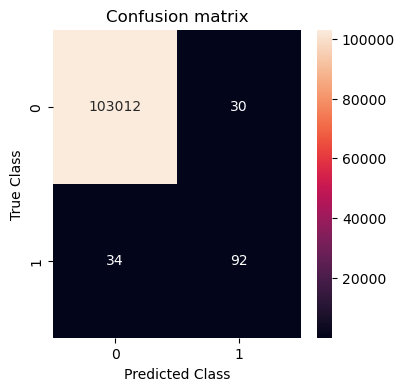

In [121]:
## CatBoost Method
model_cb = CatBoostClassifier(random_state=11)
model_cb.fit(X_resampled2_smote,y_resampled2_smote, verbose=50)
predicted = model_cb.predict(X_test2)
print('Classification report:\n', classification_report(y_test2, predicted))
print('Share of Non-Fraud in Test Data:', 1-round(y_test2[y_test2==1].count()/len(y_test2),4))
print('F1 score of catboost is {}'.format(f1_score(y_test2, predicted)))
print('Accuracy of catboost is {}'.format(accuracy_score(y_test2, predicted)))
print("ROC-AUC Score:")
print(roc_auc_score(y_test2,  predicted))

conf_mat = confusion_matrix(y_true=y_test2, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_mat, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

In [ ]:
# from sklearn.svm import LinearSVC
# model_svc = LinearSVC(class_weight='balanced')
# model_svc.fit(X_resampled2_smote,y_resampled2_smote)
# predicted = model_svc.predict(X_test2)
# print('Classification report:\n', classification_report(y_test2, predicted))
# conf_mat = confusion_matrix(y_true=y_test2, y_pred=predicted)
# print('Confusion matrix:\n', conf_mat)
# print('Share of Non-Fraud in Test Data:', 1-round(y_test2[y_test2==1].count()/len(y_test2),4))
# print('F1 score of LinearSVC is {}'.format(f1_score(y_test2, predicted)))
# print('Accuracy of LinearSVC is {}'.format(accuracy_score(y_test2, predicted)))
# print("ROC-AUC Score:")
# print(roc_auc_score(y_test2,  predicted))

In [122]:
#DT Classifier
dtree = DecisionTreeClassifier(random_state=11)
dtree.fit(X_resampled2_smote,y_resampled2_smote)
predicted = dtree.predict(X_test2)
print('Classification report:\n', classification_report(y_test2, predicted))
conf_mat = confusion_matrix(y_true=y_test2, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)
print('Share of Non-Fraud in Test Data:', 1-round(y_test2[y_test2==1].count()/len(y_test2),4))
print('F1 score of Decision Tree is {}'.format(f1_score(y_test2, predicted)))
print('Accuracy of Decision Tree is {}'.format(accuracy_score(y_test2, predicted)))
print("ROC-AUC Score:")
print(roc_auc_score(y_test2,  predicted))

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    103042
           1       0.63      0.67      0.65       126

    accuracy                           1.00    103168
   macro avg       0.82      0.84      0.83    103168
weighted avg       1.00      1.00      1.00    103168

Confusion matrix:
 [[102993     49]
 [    41     85]]
Share of Non-Fraud in Test Data: 0.9988
F1 score of Decision Tree is 0.653846153846154
Accuracy of Decision Tree is 0.9991276364764268
ROC-AUC Score:
0.837063820177502


### Based on results above, we see most of the Tree based models are performing ay better than the baseline model ; we will try tuning parameters of some below

### 5.4🔰  ***************************************Hyperparams Tuning**************************************************** (for XGB & Catboost Models)

### Randomized Search Hyper param tuning of XGB

In [270]:
# Hyperparameters Tuning for RF

# Suppress all warnings
warnings.simplefilter("ignore")

# Define the hyperparameters
param_rf = {
    'n_estimators': [50,100,150,200,250],
    'max_depth': [20,30,40,50,60],
    'max_features': ['sqrt'],  # kept 'sqrt' --, 'log2'
    'min_samples_split': [2, 5], #min samples needed to split node
    'min_samples_leaf': [1, 2],  #min samples needed at each leaf node
    'bootstrap': [True, False]
}
random_search_rf = RandomizedSearchCV(estimator=model_rf, param_distributions=param_rf, 
                           cv=3,n_iter=5, verbose=3,random_state=11, scoring='roc_auc') 

random_search_rf.fit(X_resampled2_smote, y_resampled2_smote)

# Get the best hyperparameters
best_params = random_search_rf.best_params_
best_rf=random_search_rf.best_estimator_
print("Best hyperparameters:", best_params)

y_pred_best_rf = best_rf.predict(X_test2)

print("RF Results with Best Hyperparameters:")
print(classification_report(y_test2, y_pred_best_rf))
print(confusion_matrix(y_test2, y_pred_best_rf))
print("ROC-AUC Score:")
print(roc_auc_score(y_test2,  y_pred_best_rf))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=250;, score=1.000 total time= 2.4min
[CV 2/3] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=250;, score=1.000 total time= 2.8min
[CV 3/3] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=250;, score=1.000 total time= 2.8min
[CV 1/3] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=1.000 total time= 1.5min
[CV 2/3] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=1.000 total time= 1.6min
[CV 3/3] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=1.000 total time= 1.9min
[CV 1/3] END bootst

In [123]:
# Hyperparameters Tuning for XGB
param_xgb = {
    'learning_rate': [0.05,0.1,0.2,0.3],
    'max_depth': [2,3,4,5,6,8],
    'min_child_weight': [1,3,5,7],  # Removed 'auto' and kept 'sqrt' --, 'log2'
    'gamma': [0.0, 0.2,0.4], #min samples needed to split node
    'colsample_bytree': [0.3,0.5,0.7],  #min samples needed at each leaf node
}
random_search = RandomizedSearchCV(estimator=model_xgb, param_distributions=param_xgb, 
                           cv=3,n_iter=5, n_jobs=-1, verbose=3, scoring='roc_auc',random_state=11) 

random_search.fit(X_resampled2_smote, y_resampled2_smote)

# Get the best hyperparameters
best_params = random_search.best_params_
best_xgb=random_search.best_estimator_
print("Best hyperparameters:", best_params)

y_pred_best_xgb = best_xgb.predict(X_test2)

print("XGB Results with Best Hyperparameters:")
# print(classification_report(y_test2, y_pred_best_xgb))
# print(confusion_matrix(y_test2, y_pred_best_xgb))
print('Classification report:\n', classification_report(y_test2, y_pred_best_xgb))
conf_mat = confusion_matrix(y_true=y_test2, y_pred=y_pred_best_xgb)
print('Confusion matrix:\n', conf_mat)
print('Share of Non-Fraud in Test Data:', 1-round(y_test2[y_test2==1].count()/len(y_test2),4))
print('F1 score of best XGB is {}'.format(f1_score(y_test2, y_pred_best_xgb)))
print('Accuracy of best XGB is {}'.format(accuracy_score(y_test2, y_pred_best_xgb)))
print("ROC-AUC Score:")
print(roc_auc_score(y_test2,  y_pred_best_xgb))


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best hyperparameters: {'min_child_weight': 7, 'max_depth': 6, 'learning_rate': 0.3, 'gamma': 0.0, 'colsample_bytree': 0.3}
XGB Results with Best Hyperparameters:
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    103042
           1       0.86      0.65      0.74       126

    accuracy                           1.00    103168
   macro avg       0.93      0.83      0.87    103168
weighted avg       1.00      1.00      1.00    103168

Confusion matrix:
 [[103029     13]
 [    44     82]]
Share of Non-Fraud in Test Data: 0.9988
F1 score of best XGB is 0.7420814479638009
Accuracy of best XGB is 0.999447503101737
ROC-AUC Score:
0.8253337443230885


### Hyper param tuning of XGB with Optuna

In [124]:
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'booster': 'gbtree',
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }
    
    model_xgb_optuna = XGBClassifier(random_state=11, **params)
    model_xgb_optuna.fit(X_resampled2_smote,y_resampled2_smote)
    predictions = model_xgb_optuna.predict(X_test2)
    f1 = f1_score(y_test2, predictions)
    return f1

In [125]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
print('Best hyperparameters:', study.best_params)
print('Best F1 Score:', study.best_value)

[I 2023-11-14 13:44:55,180] A new study created in memory with name: no-name-3f2fdeee-f74a-43da-8f4b-d0a3699fba41
[I 2023-11-14 13:46:14,407] Trial 0 finished with value: 0.5573770491803278 and parameters: {'n_estimators': 287, 'max_depth': 6, 'learning_rate': 0.0317462114099628, 'subsample': 0.5407681272123349, 'colsample_bytree': 0.8222085856080787, 'min_child_weight': 9}. Best is trial 0 with value: 0.5573770491803278.
[I 2023-11-14 13:46:42,985] Trial 1 finished with value: 0.7463768115942029 and parameters: {'n_estimators': 65, 'max_depth': 10, 'learning_rate': 0.08536699682635712, 'subsample': 0.9000854680876493, 'colsample_bytree': 0.6885124351308185, 'min_child_weight': 3}. Best is trial 1 with value: 0.7463768115942029.
[I 2023-11-14 13:47:06,929] Trial 2 finished with value: 0.1589310829817159 and parameters: {'n_estimators': 76, 'max_depth': 6, 'learning_rate': 0.04315845303012718, 'subsample': 0.9482530183715712, 'colsample_bytree': 0.7924187147045811, 'min_child_weight': 4

[CV 2/3] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=7;, score=1.000 total time= 1.3min


[I 2023-11-14 13:48:35,884] Trial 3 finished with value: 0.6928571428571428 and parameters: {'n_estimators': 181, 'max_depth': 9, 'learning_rate': 0.03861683641247835, 'subsample': 0.6204342165082349, 'colsample_bytree': 0.9583459413267654, 'min_child_weight': 1}. Best is trial 1 with value: 0.7463768115942029.


[CV 3/3] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=4, min_child_weight=1;, score=1.000 total time=  56.6s
[CV 1/3] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.2, max_depth=2, min_child_weight=3;, score=1.000 total time=  36.1s
[CV 2/3] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=4, min_child_weight=1;, score=1.000 total time=  56.8s
[CV 2/3] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.2, max_depth=2, min_child_weight=3;, score=1.000 total time=  36.2s
[CV 2/3] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=7;, score=1.000 total time= 1.3min
[CV 1/3] END colsample_bytree=0.3, gamma=0.4, learning_rate=0.3, max_depth=3, min_child_weight=3;, score=1.000 total time=  33.0s
[CV 1/3] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=7;, score=1.000 total time= 1.3min
[CV 3/3] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.2, max_depth=2, min_child_we

[I 2023-11-14 13:49:36,510] Trial 4 finished with value: 0.24507658643326044 and parameters: {'n_estimators': 141, 'max_depth': 8, 'learning_rate': 0.018310149956573943, 'subsample': 0.6616508839292499, 'colsample_bytree': 0.856450351542734, 'min_child_weight': 7}. Best is trial 1 with value: 0.7463768115942029.
[I 2023-11-14 13:51:14,452] Trial 5 finished with value: 0.725 and parameters: {'n_estimators': 249, 'max_depth': 10, 'learning_rate': 0.06958135002760774, 'subsample': 0.6272822698864235, 'colsample_bytree': 0.7340028371665639, 'min_child_weight': 6}. Best is trial 1 with value: 0.7463768115942029.
[I 2023-11-14 13:52:17,307] Trial 6 finished with value: 0.7258064516129032 and parameters: {'n_estimators': 169, 'max_depth': 8, 'learning_rate': 0.07000287504538019, 'subsample': 0.5654244401295799, 'colsample_bytree': 0.7200419587245381, 'min_child_weight': 4}. Best is trial 1 with value: 0.7463768115942029.
[I 2023-11-14 13:53:30,866] Trial 7 finished with value: 0.6982758620689

Best hyperparameters: {'n_estimators': 107, 'max_depth': 10, 'learning_rate': 0.07658499823308433, 'subsample': 0.7851467863835301, 'colsample_bytree': 0.6206574217285579, 'min_child_weight': 3}
Best F1 Score: 0.7716535433070867


In [129]:
best_params=study.best_params
tuned_xgb_model=XGBClassifier(n_estimators=best_params['n_estimators'],max_depth=best_params['max_depth'],learning_rate=best_params['learning_rate']
                                    ,subsample=best_params['subsample'],colsample_bytree=best_params['colsample_bytree']
                                    ,min_child_weight=best_params['min_child_weight'],random_state=11)
tuned_xgb_model.fit(X_resampled2_smote,y_resampled2_smote)
y_pred_xgb_optuna=tuned_xgb_model.predict(X_test2)
print("XGboost Results with Best Hyperparameters with Optuna:")
# print(classification_report(y_test2, y_pred_best_xgb))
# print(confusion_matrix(y_test2, y_pred_best_xgb))
print('Classification report:\n', classification_report(y_test2, y_pred_xgb_optuna))
conf_mat = confusion_matrix(y_true=y_test2, y_pred=y_pred_xgb_optuna)
print('Confuhttp://localhost:8888/notebooks/DSTrack_Fraud_Modeling-withallvariables.ipynb#sion matrix:\n', conf_mat)
print('Share of Non-Fraud in Test Data:', 1-round(y_test2[y_test2==1].count()/len(y_test2),4))
print('F1 score of best XGB is {}'.format(f1_score(y_test2, y_pred_xgb_optuna)))
print('Accuracy of best XGB is {}'.format(accuracy_score(y_test2, y_pred_xgb_optuna)))
print("ROC-AUC Score:")
print(roc_auc_score(y_test2,  y_pred_xgb_optuna))

XGboost Results with Best Hyperparameters with Optuna:
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    103042
           1       0.77      0.78      0.77       126

    accuracy                           1.00    103168
   macro avg       0.88      0.89      0.89    103168
weighted avg       1.00      1.00      1.00    103168

Confuhttp://localhost:8888/notebooks/DSTrack_Fraud_Modeling-withallvariables.ipynb#sion matrix:
 [[103012     30]
 [    28     98]]
Share of Non-Fraud in Test Data: 0.9988
F1 score of best XGB is 0.7716535433070867
Accuracy of best XGB is 0.9994378101736973
ROC-AUC Score:
0.8887433171802652
777:	learn: 0.0137023	total: 2m 49s	remaining: 48.4s
778:	learn: 0.0136643	total: 2m 49s	remaining: 48.1s
779:	learn: 0.0136290	total: 2m 49s	remaining: 47.9s
780:	learn: 0.0135801	total: 2m 50s	remaining: 47.7s
781:	learn: 0.0135592	total: 2m 50s	remaining: 47.5s
782:	learn: 0.0135459	total: 2m 50s	r

/Users/royscrolls/opt/anaconda3/envs/getting_started_snowpark_python/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/royscrolls/opt/anaconda3/envs/getting_started_snowpark_python/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/royscrolls/opt/anaconda3/envs/getting_started_snowpark_python/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_d

715:	learn: 0.0011532	total: 2m 18s	remaining: 54.9s
716:	learn: 0.0011532	total: 2m 18s	remaining: 54.7s
717:	learn: 0.0011532	total: 2m 18s	remaining: 54.5s
718:	learn: 0.0011119	total: 2m 18s	remaining: 54.3s
719:	learn: 0.0011119	total: 2m 19s	remaining: 54.1s
720:	learn: 0.0011119	total: 2m 19s	remaining: 53.9s
721:	learn: 0.0011119	total: 2m 19s	remaining: 53.6s
722:	learn: 0.0011119	total: 2m 19s	remaining: 53.4s
723:	learn: 0.0011119	total: 2m 19s	remaining: 53.2s
724:	learn: 0.0011119	total: 2m 19s	remaining: 53s
725:	learn: 0.0011119	total: 2m 19s	remaining: 52.8s
726:	learn: 0.0011119	total: 2m 20s	remaining: 52.6s
727:	learn: 0.0011119	total: 2m 20s	remaining: 52.4s
728:	learn: 0.0011118	total: 2m 20s	remaining: 52.2s
729:	learn: 0.0011118	total: 2m 20s	remaining: 52s
730:	learn: 0.0011118	total: 2m 20s	remaining: 51.8s
731:	learn: 0.0011118	total: 2m 20s	remaining: 51.5s
732:	learn: 0.0011118	total: 2m 20s	remaining: 51.3s
733:	learn: 0.0011118	total: 2m 21s	remaining: 51.

/Users/royscrolls/opt/anaconda3/envs/getting_started_snowpark_python/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/royscrolls/opt/anaconda3/envs/getting_started_snowpark_python/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/royscrolls/opt/anaconda3/envs/getting_started_snowpark_python/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_d

### Randomized Search Hyper param tuning of Catboost

In [127]:
# Hyperparameters Tuning for Catboost
## six main params to consider : No. of trees/ iterations, learning rate, tree depth (complexity), subsample, colsample_bylevel (sampling few features), min_data_in_leaf (min samples for splitting)
param_catb = {
    'learning_rate': [0.01,0.05,0.1,0.15,0.2,0.25,0.3],
    'max_depth': [3,4,5,6,7,8,9,10],
}
random_search = RandomizedSearchCV(estimator=model_cb, param_distributions=param_catb, 
                           cv=3, scoring='roc_auc',random_state=11,n_jobs=-1) 

random_search.fit(X_resampled2_smote, y_resampled2_smote)


0:	learn: 0.2788134	total: 214ms	remaining: 3m 33s
1:	learn: 0.1713935	total: 363ms	remaining: 3m
2:	learn: 0.1336820	total: 505ms	remaining: 2m 47s
3:	learn: 0.1130378	total: 638ms	remaining: 2m 38s
4:	learn: 0.0960152	total: 778ms	remaining: 2m 34s
5:	learn: 0.0873936	total: 911ms	remaining: 2m 30s
6:	learn: 0.0745078	total: 1.05s	remaining: 2m 28s
7:	learn: 0.0655617	total: 1.18s	remaining: 2m 26s
8:	learn: 0.0582299	total: 1.33s	remaining: 2m 26s
9:	learn: 0.0488616	total: 1.47s	remaining: 2m 25s
10:	learn: 0.0439944	total: 1.6s	remaining: 2m 24s
11:	learn: 0.0402423	total: 1.74s	remaining: 2m 23s
12:	learn: 0.0375784	total: 1.86s	remaining: 2m 20s
13:	learn: 0.0350195	total: 2s	remaining: 2m 20s
14:	learn: 0.0325434	total: 2.11s	remaining: 2m 18s
15:	learn: 0.0304947	total: 2.26s	remaining: 2m 18s
16:	learn: 0.0295280	total: 2.41s	remaining: 2m 19s
17:	learn: 0.0273214	total: 2.58s	remaining: 2m 20s
18:	learn: 0.0251159	total: 2.7s	remaining: 2m 19s
19:	learn: 0.0237298	total: 2.8

/Users/royscrolls/opt/anaconda3/envs/getting_started_snowpark_python/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 0.4510605	total: 96.4ms	remaining: 1m 36s
1:	learn: 0.3255402	total: 160ms	remaining: 1m 19s
2:	learn: 0.2344502	total: 226ms	remaining: 1m 15s
3:	learn: 0.1778050	total: 294ms	remaining: 1m 13s
4:	learn: 0.1413893	total: 368ms	remaining: 1m 13s
5:	learn: 0.1153399	total: 438ms	remaining: 1m 12s
6:	learn: 0.0989451	total: 511ms	remaining: 1m 12s
7:	learn: 0.0843411	total: 587ms	remaining: 1m 12s
8:	learn: 0.0688525	total: 667ms	remaining: 1m 13s
9:	learn: 0.0580683	total: 740ms	remaining: 1m 13s
10:	learn: 0.0519434	total: 813ms	remaining: 1m 13s
11:	learn: 0.0484480	total: 887ms	remaining: 1m 13s
12:	learn: 0.0431280	total: 960ms	remaining: 1m 12s
13:	learn: 0.0376947	total: 1.03s	remaining: 1m 12s
14:	learn: 0.0350714	total: 1.11s	remaining: 1m 12s
15:	learn: 0.0324809	total: 1.17s	remaining: 1m 12s
16:	learn: 0.0300288	total: 1.24s	remaining: 1m 11s
17:	learn: 0.0269879	total: 1.32s	remaining: 1m 11s
18:	learn: 0.0247711	total: 1.39s	remaining: 1m 11s
19:	learn: 0.0234087	

RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7f8a8072b130>,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.15,
                                                          0.2, 0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10]},
                   random_state=11, scoring='roc_auc')

In [128]:
# Get the best hyperparameters for Catboost
best_params = random_search.best_params_
best_catb=random_search.best_estimator_
print("Best hyperparameters:", best_params)

y_pred_best_catb = best_catb.predict(X_test2)

print("Catboost Results with Best Hyperparameters:")
# print(classification_report(y_test2, y_pred_best_xgb))
# print(confusion_matrix(y_test2, y_pred_best_xgb))
print('Classification report:\n', classification_report(y_test2, y_pred_best_catb))
conf_mat = confusion_matrix(y_true=y_test2, y_pred=y_pred_best_catb)
print('Confuhttp://localhost:8888/notebooks/DSTrack_Fraud_Modeling-withallvariables.ipynb#sion matrix:\n', conf_mat)
print('Share of Non-Fraud in Test Data:', 1-round(y_test2[y_test2==1].count()/len(y_test2),4))
print('F1 score of best XGB is {}'.format(f1_score(y_test2, y_pred_best_catb)))
print('Accuracy of best XGB is {}'.format(accuracy_score(y_test2, y_pred_best_catb)))
print("ROC-AUC Score:")
print(roc_auc_score(y_test2,  y_pred_best_catb))

Best hyperparameters: {'max_depth': 9, 'learning_rate': 0.1}
Catboost Results with Best Hyperparameters:
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    103042
           1       0.76      0.70      0.73       126

    accuracy                           1.00    103168
   macro avg       0.88      0.85      0.86    103168
weighted avg       1.00      1.00      1.00    103168

Confuhttp://localhost:8888/notebooks/DSTrack_Fraud_Modeling-withallvariables.ipynb#sion matrix:
 [[103014     28]
 [    38     88]]
Share of Non-Fraud in Test Data: 0.9988
F1 score of best XGB is 0.7272727272727273
Accuracy of best XGB is 0.9993602667493796
ROC-AUC Score:
0.8490704822783005


In [185]:
# conda install -c conda-forge optuna

### Hyper param tuning of Catboost with Optuna

In [130]:
def objective(trial):
    params = {
        #"iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model_cb_optuna = CatBoostClassifier(random_state=11, **params, silent=True)
    model_cb_optuna.fit(X_resampled2_smote,y_resampled2_smote)
    predictions = model_cb_optuna.predict(X_test2)
    f1 = f1_score(y_test2, predictions)
    return f1

/Users/royscrolls/opt/anaconda3/envs/getting_started_snowpark_python/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/royscrolls/opt/anaconda3/envs/getting_started_snowpark_python/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/royscrolls/opt/anaconda3/envs/getting_started_snowpark_python/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_d

713:	learn: 0.0010868	total: 2m 11s	remaining: 52.7s
714:	learn: 0.0010868	total: 2m 11s	remaining: 52.5s
715:	learn: 0.0010868	total: 2m 11s	remaining: 52.3s
716:	learn: 0.0010868	total: 2m 11s	remaining: 52.1s
717:	learn: 0.0010868	total: 2m 12s	remaining: 51.9s
718:	learn: 0.0010868	total: 2m 12s	remaining: 51.7s
719:	learn: 0.0010868	total: 2m 12s	remaining: 51.5s
720:	learn: 0.0010868	total: 2m 12s	remaining: 51.3s
721:	learn: 0.0010868	total: 2m 12s	remaining: 51.1s
722:	learn: 0.0010868	total: 2m 12s	remaining: 51s
723:	learn: 0.0010868	total: 2m 13s	remaining: 50.8s
724:	learn: 0.0010868	total: 2m 13s	remaining: 50.6s
725:	learn: 0.0010868	total: 2m 13s	remaining: 50.4s
726:	learn: 0.0010868	total: 2m 13s	remaining: 50.2s
727:	learn: 0.0010868	total: 2m 13s	remaining: 50s
728:	learn: 0.0010868	total: 2m 13s	remaining: 49.8s
729:	learn: 0.0010868	total: 2m 14s	remaining: 49.6s
730:	learn: 0.0010868	total: 2m 14s	remaining: 49.4s
731:	learn: 0.0010868	total: 2m 14s	remaining: 49.

/Users/royscrolls/opt/anaconda3/envs/getting_started_snowpark_python/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/royscrolls/opt/anaconda3/envs/getting_started_snowpark_python/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/royscrolls/opt/anaconda3/envs/getting_started_snowpark_python/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_d

In [131]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
print('Best hyperparameters:', study.best_params)
print('Best F1 Score:', study.best_value)

[I 2023-11-14 14:21:54,547] A new study created in memory with name: no-name-cc6e045e-5a2c-49f6-be10-446f5ee63852
/Users/royscrolls/opt/anaconda3/envs/getting_started_snowpark_python/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


713:	learn: 0.0013211	total: 1m 33s	remaining: 37.5s
714:	learn: 0.0013211	total: 1m 33s	remaining: 37.4s
715:	learn: 0.0013211	total: 1m 33s	remaining: 37.2s
716:	learn: 0.0013211	total: 1m 33s	remaining: 37.1s
717:	learn: 0.0013211	total: 1m 33s	remaining: 36.9s
718:	learn: 0.0013211	total: 1m 34s	remaining: 36.8s
719:	learn: 0.0013211	total: 1m 34s	remaining: 36.6s
720:	learn: 0.0013211	total: 1m 34s	remaining: 36.5s
721:	learn: 0.0013211	total: 1m 34s	remaining: 36.3s
722:	learn: 0.0013210	total: 1m 34s	remaining: 36.1s
723:	learn: 0.0013210	total: 1m 34s	remaining: 36s
724:	learn: 0.0013210	total: 1m 34s	remaining: 35.8s
725:	learn: 0.0013210	total: 1m 34s	remaining: 35.7s
726:	learn: 0.0013210	total: 1m 34s	remaining: 35.5s
727:	learn: 0.0013210	total: 1m 34s	remaining: 35.4s
728:	learn: 0.0013210	total: 1m 34s	remaining: 35.2s
729:	learn: 0.0013210	total: 1m 34s	remaining: 35.1s
730:	learn: 0.0013210	total: 1m 34s	remaining: 34.9s
731:	learn: 0.0013210	total: 1m 34s	remaining: 3

/Users/royscrolls/opt/anaconda3/envs/getting_started_snowpark_python/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/royscrolls/opt/anaconda3/envs/getting_started_snowpark_python/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/royscrolls/opt/anaconda3/envs/getting_started_snowpark_python/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_d

714:	learn: 0.0008502	total: 1m 35s	remaining: 38.1s
715:	learn: 0.0008502	total: 1m 35s	remaining: 38s
716:	learn: 0.0008502	total: 1m 35s	remaining: 37.8s
717:	learn: 0.0008502	total: 1m 35s	remaining: 37.6s
718:	learn: 0.0008502	total: 1m 35s	remaining: 37.5s
719:	learn: 0.0008502	total: 1m 36s	remaining: 37.3s
720:	learn: 0.0008502	total: 1m 36s	remaining: 37.2s
721:	learn: 0.0008502	total: 1m 36s	remaining: 37s
722:	learn: 0.0008502	total: 1m 36s	remaining: 36.9s
723:	learn: 0.0008502	total: 1m 36s	remaining: 36.7s
724:	learn: 0.0008502	total: 1m 36s	remaining: 36.6s
725:	learn: 0.0008502	total: 1m 36s	remaining: 36.4s
726:	learn: 0.0008502	total: 1m 36s	remaining: 36.3s
727:	learn: 0.0008502	total: 1m 36s	remaining: 36.1s
728:	learn: 0.0008502	total: 1m 36s	remaining: 36s
729:	learn: 0.0008502	total: 1m 36s	remaining: 35.8s
730:	learn: 0.0008502	total: 1m 36s	remaining: 35.7s
731:	learn: 0.0008502	total: 1m 37s	remaining: 35.5s
732:	learn: 0.0008501	total: 1m 37s	remaining: 35.4s

/Users/royscrolls/opt/anaconda3/envs/getting_started_snowpark_python/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/royscrolls/opt/anaconda3/envs/getting_started_snowpark_python/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/royscrolls/opt/anaconda3/envs/getting_started_snowpark_python/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_d

719:	learn: 0.0016201	total: 1m 27s	remaining: 33.9s
720:	learn: 0.0016201	total: 1m 27s	remaining: 33.8s
721:	learn: 0.0016201	total: 1m 27s	remaining: 33.7s
722:	learn: 0.0016201	total: 1m 27s	remaining: 33.5s
723:	learn: 0.0016201	total: 1m 27s	remaining: 33.4s
724:	learn: 0.0016201	total: 1m 27s	remaining: 33.3s
725:	learn: 0.0016201	total: 1m 27s	remaining: 33.1s
726:	learn: 0.0016201	total: 1m 27s	remaining: 33s
727:	learn: 0.0016201	total: 1m 28s	remaining: 32.9s
728:	learn: 0.0016201	total: 1m 28s	remaining: 32.8s
729:	learn: 0.0016201	total: 1m 28s	remaining: 32.6s
730:	learn: 0.0016201	total: 1m 28s	remaining: 32.5s
731:	learn: 0.0016201	total: 1m 28s	remaining: 32.4s
732:	learn: 0.0016201	total: 1m 28s	remaining: 32.2s
733:	learn: 0.0016201	total: 1m 28s	remaining: 32.1s
734:	learn: 0.0016201	total: 1m 28s	remaining: 32s
735:	learn: 0.0016201	total: 1m 28s	remaining: 31.8s
736:	learn: 0.0016201	total: 1m 28s	remaining: 31.7s
737:	learn: 0.0016201	total: 1m 28s	remaining: 31.

/Users/royscrolls/opt/anaconda3/envs/getting_started_snowpark_python/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/royscrolls/opt/anaconda3/envs/getting_started_snowpark_python/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/royscrolls/opt/anaconda3/envs/getting_started_snowpark_python/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_d

710:	learn: 0.0010595	total: 1m 19s	remaining: 32.4s
711:	learn: 0.0010595	total: 1m 19s	remaining: 32.3s
712:	learn: 0.0010595	total: 1m 19s	remaining: 32.1s
713:	learn: 0.0010595	total: 1m 19s	remaining: 32s
714:	learn: 0.0010595	total: 1m 19s	remaining: 31.9s
715:	learn: 0.0010595	total: 1m 20s	remaining: 31.7s
716:	learn: 0.0010595	total: 1m 20s	remaining: 31.6s
717:	learn: 0.0010595	total: 1m 20s	remaining: 31.5s
718:	learn: 0.0010594	total: 1m 20s	remaining: 31.4s
719:	learn: 0.0010594	total: 1m 20s	remaining: 31.2s
720:	learn: 0.0010594	total: 1m 20s	remaining: 31.1s
721:	learn: 0.0010594	total: 1m 20s	remaining: 31s
722:	learn: 0.0010594	total: 1m 20s	remaining: 30.8s
723:	learn: 0.0010594	total: 1m 20s	remaining: 30.7s
724:	learn: 0.0010594	total: 1m 20s	remaining: 30.6s
725:	learn: 0.0010593	total: 1m 20s	remaining: 30.5s
726:	learn: 0.0010593	total: 1m 20s	remaining: 30.3s
727:	learn: 0.0010593	total: 1m 20s	remaining: 30.2s
728:	learn: 0.0010593	total: 1m 20s	remaining: 30.

/Users/royscrolls/opt/anaconda3/envs/getting_started_snowpark_python/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/royscrolls/opt/anaconda3/envs/getting_started_snowpark_python/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/royscrolls/opt/anaconda3/envs/getting_started_snowpark_python/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_d

Best hyperparameters: {'learning_rate': 0.09772390609703906, 'depth': 8, 'subsample': 0.7511743275207953, 'colsample_bylevel': 0.9934458569560028, 'min_data_in_leaf': 22}
Best F1 Score: 0.7642276422764228


In [132]:
best_params=study.best_params
tuned_catb_model=CatBoostClassifier(depth=best_params['depth'],learning_rate=best_params['learning_rate']
                                    ,subsample=best_params['subsample'],colsample_bylevel=best_params['colsample_bylevel']
                                    ,min_data_in_leaf=best_params['min_data_in_leaf'],random_state=11)
tuned_catb_model.fit(X_resampled2_smote,y_resampled2_smote)
y_pred_catb_optuna=tuned_catb_model.predict(X_test2)
print("Catboost Results with Best Hyperparameters with Optuna:")
# print(classification_report(y_test2, y_pred_best_xgb))
# print(confusion_matrix(y_test2, y_pred_best_xgb))
print('Classification report:\n', classification_report(y_test2, y_pred_catb_optuna))
conf_mat = confusion_matrix(y_true=y_test2, y_pred=y_pred_catb_optuna)
print('Confuhttp://localhost:8888/notebooks/DSTrack_Fraud_Modeling-withallvariables.ipynb#sion matrix:\n', conf_mat)
print('Share of Non-Fraud in Test Data:', 1-round(y_test2[y_test2==1].count()/len(y_test2),4))
print('F1 score of best XGB is {}'.format(f1_score(y_test2, y_pred_catb_optuna)))
print('Accuracy of best XGB is {}'.format(accuracy_score(y_test2, y_pred_catb_optuna)))
print("ROC-AUC Score:")
print(roc_auc_score(y_test2,  y_pred_catb_optuna))

/Users/royscrolls/opt/anaconda3/envs/getting_started_snowpark_python/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 0.4587674	total: 63.1ms	remaining: 1m 3s
1:	learn: 0.3172744	total: 112ms	remaining: 55.9s
2:	learn: 0.2316847	total: 157ms	remaining: 52.2s
3:	learn: 0.1825865	total: 205ms	remaining: 51.1s
4:	learn: 0.1467343	total: 251ms	remaining: 49.9s
5:	learn: 0.1241530	total: 304ms	remaining: 50.3s
6:	learn: 0.1063551	total: 352ms	remaining: 49.9s
7:	learn: 0.0927317	total: 396ms	remaining: 49.1s
8:	learn: 0.0748628	total: 445ms	remaining: 48.9s
9:	learn: 0.0672260	total: 491ms	remaining: 48.6s
10:	learn: 0.0605714	total: 543ms	remaining: 48.8s
11:	learn: 0.0544580	total: 596ms	remaining: 49s
12:	learn: 0.0494904	total: 647ms	remaining: 49.1s
13:	learn: 0.0464767	total: 693ms	remaining: 48.8s
14:	learn: 0.0423264	total: 742ms	remaining: 48.8s
15:	learn: 0.0374592	total: 801ms	remaining: 49.3s
16:	learn: 0.0351501	total: 848ms	remaining: 49s
17:	learn: 0.0330309	total: 891ms	remaining: 48.6s
18:	learn: 0.0309631	total: 942ms	remaining: 48.6s
19:	learn: 0.0282578	total: 992ms	remaining:

### Hyperparam Tuning gives the best Estimator which has a precision score of 77%, recall of 72% and f1-score of 0.75 ;  ------> 0.77      0.72      0.75; (ROC_AUC score= 0.87)

In [133]:
#feature imp for catb model tuned
feature_importances = tuned_catb_model.feature_importances_
importances_df = pd.DataFrame({'Feature': range(X.shape[1]), 'Importance': feature_importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Print or visualize feature importances
#print(importances_df)

In [134]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [135]:
#feature imp for xgb model tuned
feature_importances = tuned_xgb_model.feature_importances_
importances_df = pd.DataFrame({'Feature': range(X.shape[1]), 'Importance': feature_importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)
fig = optuna.visualization.plot_param_importances(study)
fig.show()

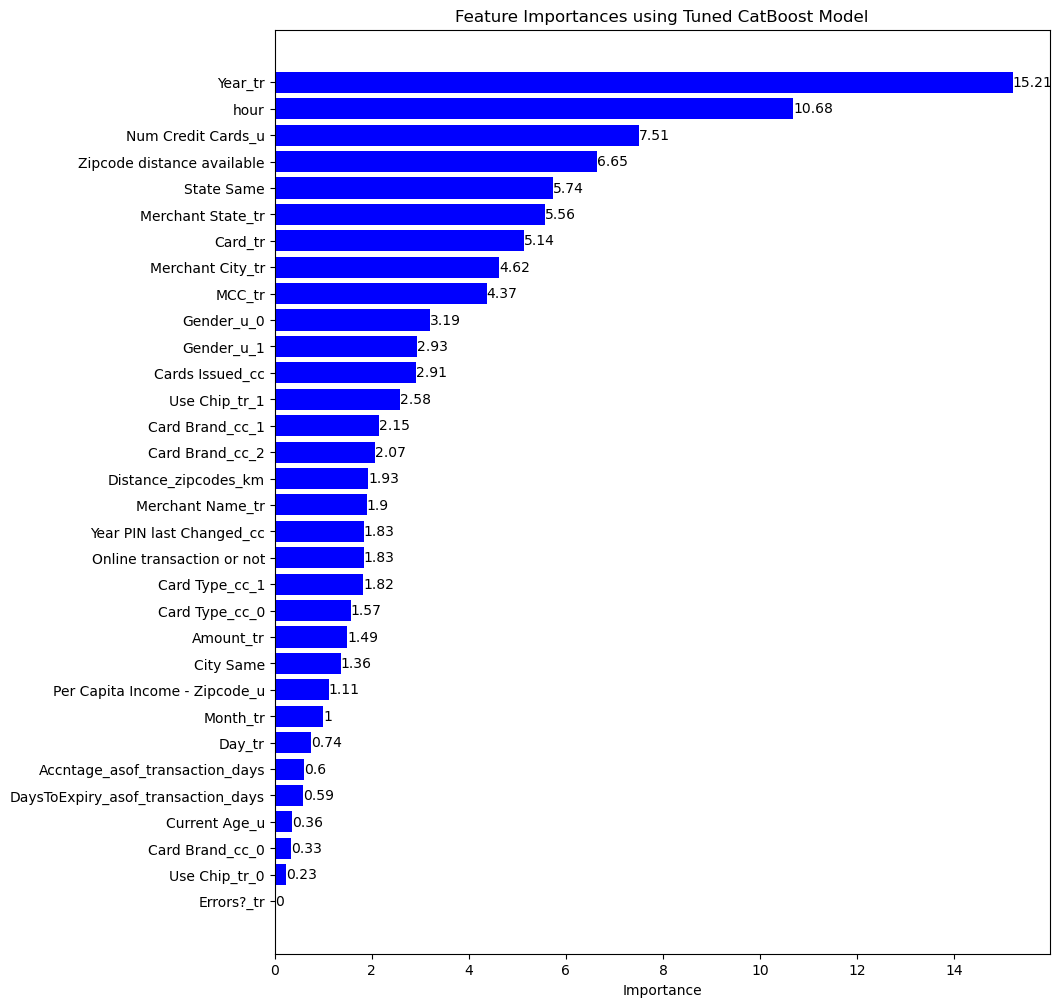

In [136]:
# Extract feature importances from the best random forest model
feature_importance = np.round( tuned_catb_model.feature_importances_,2)
features = X_resampled2_smote.columns

# Sort the feature importances and their corresponding feature names
sorted_idx = feature_importance.argsort()

# Plot horizontal bar chart
plt.figure(figsize=(10, 12))
ax=plt.barh(features[sorted_idx], feature_importance[sorted_idx], align='center', color='blue')
plt.bar_label(ax)
plt.xlabel('Importance')
plt.title('Feature Importances using Tuned CatBoost Model')
plt.show()

### ************************************************************************************************************************************
### 6.0🔰  Advanced Models 
### ************************************************************************************************************************************

In [137]:
X_train2.shape[1]

32

In [138]:
# Define the model architecture
model1 = Sequential()
model1.add(Dense(units=64, activation='relu', kernel_initializer='he_uniform', input_dim=X_resampled2_smote.shape[1]))
model1.add(Dense(units=32, activation='relu'))
model1.add(Dense(units=1, activation='sigmoid'))
print(model1)

# model2 = Sequential()
# model2.add(InputLayer(X_train2.shape[1]))
# model2.add(Dense(units=32, activation='relu'))
# model2.add(BatchNormalization())
# model2.add(Dense(units=1, activation='sigmoid')) # value between 0 & 1

2023-11-14 15:44:02.863382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [139]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,225
Trainable params: 4,225
Non-trainable params: 0
_________________________________________________________________


In [140]:
# Compile the model
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [141]:
# Train the model with early stopping
history_model1 = model1.fit(X_train2, y_train2, epochs=10, batch_size=128)

Epoch 1/10
1881/1881 [==============================] - 3s 1ms/step - loss: 0.0123 - accuracy: 0.9968
Epoch 2/10
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0057 - accuracy: 0.9988
Epoch 3/10
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0049 - accuracy: 0.9988
Epoch 4/10
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0044 - accuracy: 0.9989
Epoch 5/10
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0039 - accuracy: 0.9990
Epoch 6/10
1881/1881 [==============================] - 3s 1ms/step - loss: 0.0035 - accuracy: 0.9991
Epoch 7/10
1881/1881 [==============================] - 3s 1ms/step - loss: 0.0032 - accuracy: 0.9992
Epoch 8/10
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0030 - accuracy: 0.9992
Epoch 9/10
1881/1881 [==============================] - 2s 1ms/step - loss: 0.0028 - accuracy: 0.9992
Epoch 10/10
1881/1881 [==============================] - 2s 1ms/step - loss: 0.002

In [142]:
# Evaluate the model on the test data
y_pred = model1.predict(X_test2)
y_pred_classes = np.round(y_pred)
# Print the confusion matrix and classification report
print('Confusion matrix:')
print(confusion_matrix(y_test2, y_pred_classes))
print('Classification report:')
print(classification_report(y_test2, y_pred_classes))
print(roc_auc_score(y_test2, y_pred_classes))

3224/3224 [==============================] - 3s 801us/step
Confusion matrix:
[[103003     39]
 [    76     50]]
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    103042
           1       0.56      0.40      0.47       126

    accuracy                           1.00    103168
   macro avg       0.78      0.70      0.73    103168
weighted avg       1.00      1.00      1.00    103168

0.6982234551914877


#### Weighted Neural networks with Keras

In [143]:
weights={0:1, 1:815} #as 0s exist 815 times that of 1

In [144]:
# Define the model architecture
model_w = Sequential()
model_w.add(Dense(units=64, activation='relu', kernel_initializer='he_uniform', input_dim=X_train.shape[1]))
model_w.add(Dense(units=32, activation='relu'))
model_w.add(Dense(units=1, activation='sigmoid'))
# Compile the model
model_w.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_w.fit(X_train2, y_train2, epochs=10, class_weight=weights,batch_size=128)

## alternative tried
# # Define the model architecture
# model_w2 = Sequential()
# model_w2.add(InputLayer(X_train2.shape[1]))
# model_w2.add(Dense(units=32, activation='relu'))
# model_w2.add(BatchNormalization())
# model_w2.add(Dense(units=1, activation='sigmoid')) # value between 0 & 1
# # Compile the model
# model_w2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# #model_w2.summary()
# model_w2.fit(X_train2, y_train2, epochs=10, class_weight=weights)

Epoch 1/10
1881/1881 [==============================] - 3s 1ms/step - loss: 0.7059 - accuracy: 0.8605
Epoch 2/10
1881/1881 [==============================] - 3s 1ms/step - loss: 0.4256 - accuracy: 0.8966
Epoch 3/10
1881/1881 [==============================] - 2s 1ms/step - loss: 0.3314 - accuracy: 0.9181
Epoch 4/10
1881/1881 [==============================] - 3s 1ms/step - loss: 0.2679 - accuracy: 0.9370
Epoch 5/10
1881/1881 [==============================] - 3s 1ms/step - loss: 0.2435 - accuracy: 0.9437
Epoch 6/10
1881/1881 [==============================] - 3s 1ms/step - loss: 0.1998 - accuracy: 0.9547
Epoch 7/10
1881/1881 [==============================] - 2s 1ms/step - loss: 0.1724 - accuracy: 0.9610
Epoch 8/10
1881/1881 [==============================] - 3s 1ms/step - loss: 0.1587 - accuracy: 0.9627
Epoch 9/10
1881/1881 [==============================] - 3s 1ms/step - loss: 0.1517 - accuracy: 0.9671
Epoch 10/10
1881/1881 [==============================] - 3s 2ms/step - loss: 0.125

In [145]:
# Evaluate the model on the test data
y_pred = model_w.predict(X_test2)
y_pred_classes = np.round(y_pred)
# Print the confusion matrix and classification report
print('Confusion matrix:')
print(confusion_matrix(y_test2, y_pred_classes))
print('Classification report:')
print(classification_report(y_test2, y_pred_classes,target_names=['Not Fraud', 'Fraud']))
print('ROC AUC Score:')
print(roc_auc_score(y_test2, y_pred_classes))

3224/3224 [==============================] - 3s 806us/step
Confusion matrix:
[[98346  4696]
 [   10   116]]
Classification report:
              precision    recall  f1-score   support

   Not Fraud       1.00      0.95      0.98    103042
       Fraud       0.02      0.92      0.05       126

    accuracy                           0.95    103168
   macro avg       0.51      0.94      0.51    103168
weighted avg       1.00      0.95      0.98    103168

ROC AUC Score:
0.9375306355275688


###  using weights in Neural Networks, the ROC AUC Score is up to 0.93 which indicates that the model is working to some extent 

### 6.1🔰 Autoencoders Implementation

In [146]:
##normal transactions
x_norm=subsample2[subsample2['Is Fraud?_tr']==0]
x_norm.drop(['Is Fraud?_tr'], axis=1,inplace=True)
##normal transactions
x_fraud=subsample2[subsample2['Is Fraud?_tr']==1]
x_fraud.drop(['Is Fraud?_tr'], axis=1,inplace=True)
print(x_norm.shape,x_fraud.shape) ## 2% of data roughly is fraud

(343471, 32) (421, 32)


/var/folders/0t/56tw317j52n02zljvtt1yxg00000gn/T/ipykernel_2258/3404535020.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/0t/56tw317j52n02zljvtt1yxg00000gn/T/ipykernel_2258/3404535020.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [147]:
x_norm.head()

Card_tr   Year_tr  Month_tr    Day_tr  Amount_tr  Merchant Name_tr  \
2503432  1.258117 -1.345410  1.587559  1.054439  -0.442745          1.825393   
2828623 -0.936087  0.444713  1.007260 -0.650771  -0.278416         -1.123202   
1409888 -0.936087  1.339775 -1.604089 -0.082368   0.602266         -1.044714   
3251937 -0.204686  1.339775  1.007260  1.395481   0.166328         -1.316088   
1395459 -0.936087 -0.450348 -1.313939 -0.764452  -0.020325          1.586360   

         Merchant City_tr  Merchant State_tr    MCC_tr  Errors?_tr  \
2503432          0.405295           0.627562  0.410939    0.091995   
2828623          0.498192           0.292460 -1.631814    0.091995   
1409888         -1.358768           0.314800  0.400725    0.091995   
3251937         -0.790918           0.471181 -0.282462    0.091995   
1395459          1.106602           1.744569  0.287239    0.091995   

         Cards Issued_cc  Year PIN last Changed_cc  Current Age_u  \
2503432        -1.006154                  0.080513       0.668618   
2828623        -1.006154                 -0.251239       0.298554   
1409888         0.929051                 -1.246494       1.655456   
3251937        -1.006154                  0.412264      -1.181703   
1395459         0.929051                  0.080513       0.113522   

         Per Capita Income - Zipcode_u  Num Credit Cards_u      hour  \
2503432                      -0.845092            0.266395 -0.470736   
2828623                       0.263274            0.266395  1.104928   
1409888                      -0.502467            0.266395  0.317096   
3251937                       0.888438           -0.971638 -2.243359   
1395459                       1.173483            0.885411  1.695803   

         Accntage_asof_transaction_days  DaysToExpiry_asof_transaction_days  \
2503432                       -1.004094                           -1.777156   
2828623                       -0.141348                           -0.953292   
1409888                        0.242293                           -0.162658   
3251937                       -0.531553                           -1.526535   
1395459                       -0.904455                           -0.029732   

         City Same  State Same  Online transaction or not  \
2503432          1           1                          0   
2828623          0           0                          1   
1409888          0           1                          0   
3251937          0           1                          0   
1395459          1           1                          0   

         Distance_zipcodes_km  Zipcode distance available  Use Chip_tr_0  \
2503432             -0.523994                           1              0   
2828623              1.974771                           0              1   
1409888             -0.513389                           1              0   
3251937             -0.521762                           1              0   
1395459             -0.523994                           1              0   

         Use Chip_tr_1  Card Brand_cc_0  Card Brand_cc_1  Card Brand_cc_2  \
2503432              1                0                1                0   
2828623              0                0                0                1   
1409888              1                0                1                0   
3251937              1                0                0                1   
1395459              1                0                0                1   

         Card Type_cc_0  Card Type_cc_1  Gender_u_0  Gender_u_1  
2503432               0               1           1           0  
2828623               1               0           0           1  
1409888               0               1           1           0  
3251937               0               1           0           1  
1395459               0               1           0           1

In [148]:
X3 = subsample2 #.drop(['Is Fraud?_tr'], axis=1)
y3 = subsample2['Is Fraud?_tr']
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.3, stratify=y3, random_state=11)
method= SMOTE()
X_resampled3_smote, y_resampled3_smote = method.fit_resample(X_train3, y_train3)

In [149]:
## doing modifications  for training sets only
X_train3_normal=X_train3[X_train3['Is Fraud?_tr']==0]
X_train3_fraud=X_train3[X_train3['Is Fraud?_tr']==1]
Xtrain_normal=X_train3_normal.drop(['Is Fraud?_tr'], axis=1)
Xtrain_fraud=X_train3_fraud.drop(['Is Fraud?_tr'], axis=1)
print(Xtrain_normal.shape, Xtrain_fraud.shape)

(240429, 32) (295, 32)


In [150]:
# transform test dataframes
X_test3_normal=X_test3[X_test3['Is Fraud?_tr']==0]
X_test3_fraud=X_test3[X_test3['Is Fraud?_tr']==1]
Xtest_normal=X_test3_normal.drop(['Is Fraud?_tr'], axis=1)
Xtest_fraud=X_test3_fraud.drop(['Is Fraud?_tr'], axis=1)
print(Xtest_normal.shape, Xtest_fraud.shape)

(103042, 32) (126, 32)


In [151]:
X_test3=X_test3.drop(['Is Fraud?_tr'], axis=1)
Xtrain_normal.head()

Card_tr   Year_tr  Month_tr    Day_tr  Amount_tr  Merchant Name_tr  \
5777457 -0.936087 -0.450348  1.297409  0.486036   0.708429         -0.795939   
2619492  0.526716 -0.450348  0.717110  1.281800  -0.253239          1.054695   
5016958  1.258117 -0.450348  1.007260  1.168120  -0.048726         -1.397010   
3063550  1.258117  0.444713  1.297409  0.599716  -0.176097         -1.311319   
5735797 -0.204686  1.339775 -0.153340 -0.082368  -0.316614         -1.123202   

         Merchant City_tr  Merchant State_tr    MCC_tr  Errors?_tr  \
5777457         -0.157321          -1.472411 -0.828331    0.091995   
2619492         -1.515777          -1.025608  0.288374    0.091995   
5016958          1.453985          -0.064982  0.466547    0.091995   
3063550         -0.354564           1.387127  2.246012    0.091995   
5735797          0.498192           0.292460 -1.631814    0.091995   

         Cards Issued_cc  Year PIN last Changed_cc  Current Age_u  \
5777457         0.929051                  0.744016      -0.318220   
2619492        -1.006154                  1.407519      -0.873316   
5016958         0.929051                  1.739271       1.408747   
3063550         0.929051                 -0.582991       0.298554   
5735797         0.929051                 -0.251239       1.408747   

         Per Capita Income - Zipcode_u  Num Credit Cards_u      hour  \
5777457                      -0.014855           -0.352622  0.317096   
2619492                       0.173360           -0.352622  0.120138   
5016958                      -0.194424            0.266395 -0.470736   
3063550                      -0.774025            0.266395 -0.273778   
5735797                      -0.382725            1.504428 -0.470736   

         Accntage_asof_transaction_days  DaysToExpiry_asof_transaction_days  \
5777457                       -1.316139                            1.094601   
2619492                       -1.820899                            1.126448   
5016958                       -1.858488                            1.298144   
3063550                        0.101486                            0.587820   
5735797                       -0.283946                            0.387046   

         City Same  State Same  Online transaction or not  \
5777457          0           1                          0   
2619492          0           0                          0   
5016958          0           1                          0   
3063550          1           1                          0   
5735797          0           0                          1   

         Distance_zipcodes_km  Zipcode distance available  Use Chip_tr_0  \
5777457             -0.523203                           1              0   
2619492             -0.335230                           1              0   
5016958             -0.500643                           1              0   
3063550             -0.523248                           1              0   
5735797              1.974771                           0              1   

         Use Chip_tr_1  Card Brand_cc_0  Card Brand_cc_1  Card Brand_cc_2  \
5777457              1                0                0                1   
2619492              1                0                1                0   
5016958              1                0                1                0   
3063550              1                0                1                0   
5735797              0                0                0                1   

         Card Type_cc_0  Card Type_cc_1  Gender_u_0  Gender_u_1  
5777457               1               0           0           1  
2619492               1               1           1           0  
5016958               1               1           1           0  
3063550               1               0           0           1  
5735797               1               1           1           0

In [153]:
# Define input layer
input_layer=Input(Xtrain_normal.shape[1])

#encoding
encoded=Dense(20,activation='tanh',activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded=Dense(10,activation='relu')(encoded)

#decoding
decoded=Dense(10,activation='tanh')(encoded)
decoded=Dense(20,activation='tanh')(decoded)

#output layer
output_layer=Dense(Xtrain_normal.shape[1],activation='sigmoid')(decoded)
        
autoencoder=Model(input_layer,output_layer)
autoencoder.compile(optimizer="adam",loss='mse')

In [154]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_11 (Dense)            (None, 20)                660       
                                                                 
 dense_12 (Dense)            (None, 10)                210       
                                                                 
 dense_13 (Dense)            (None, 10)                110       
                                                                 
 dense_14 (Dense)            (None, 20)                220       
                                                                 
 dense_15 (Dense)            (None, 32)                672       
                                                                 
Total params: 1,872
Trainable params: 1,872
Non-trainable p

In [155]:
#tensorflow.config.run_functions_eagerly(True) 
result=autoencoder.fit(Xtrain_normal,Xtrain_normal,batch_size=128,epochs=100,shuffle=True, validation_split=0.2,verbose=False)

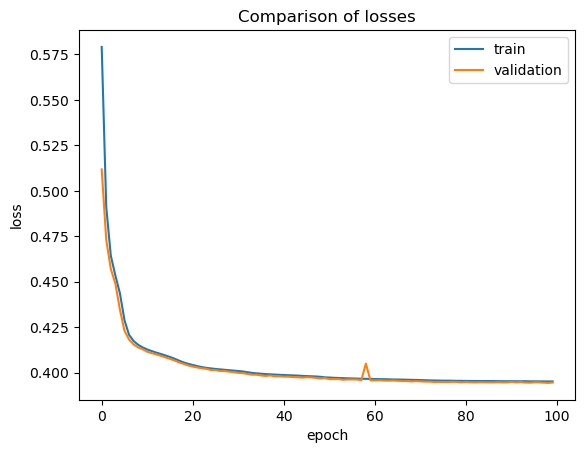

In [156]:
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('Comparison of losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='upper right')
plt.show()

In [157]:
predictions_autoencoder=autoencoder.predict(X_test3)
predictions_autoencoder ## not exactly 0 & 1

3224/3224 [==============================] - 3s 839us/step


array([[3.8064176e-16, 9.9979556e-01, 9.1142458e-05, ..., 1.0000000e+00,
        1.5414659e-03, 9.9845290e-01],
       [7.3898662e-17, 1.8588162e-07, 1.0023536e-13, ..., 1.0000000e+00,
        9.9999875e-01, 1.2447547e-06],
       [4.2189666e-07, 2.6312710e-03, 7.2642177e-04, ..., 2.9137001e-07,
        1.0000000e+00, 3.9128768e-08],
       ...,
       [6.8965787e-17, 9.9974668e-01, 2.6623183e-01, ..., 1.0000000e+00,
        1.0000000e+00, 5.5711143e-13],
       [5.7574944e-03, 1.8060425e-07, 1.4407982e-13, ..., 1.0000000e+00,
        9.9816221e-01, 1.8488660e-03],
       [9.9368280e-01, 3.4045736e-06, 2.6784290e-13, ..., 1.0000000e+00,
        9.9986750e-01, 1.3276920e-04]], dtype=float32)

In [158]:
#calculating level of loss / reconstruction error after decompressing
mse=np.mean(np.power(X_test3-predictions_autoencoder,2),axis=1)
error=pd.DataFrame({'reconstruction_error': mse, 'True_class': y_test3})
error.describe()

reconstruction_error     True_class
count         103168.000000  103168.000000
mean               0.392775       0.001221
std                0.618440       0.034926
min                0.046072       0.000000
25%                0.251593       0.000000
50%                0.325800       0.000000
75%                0.416871       0.000000
max               22.014659       1.000000

In [159]:
error_true=error[error['True_class']==0]
print("Normal Sample",error_true.describe())
error_false=error[error['True_class']==1]
print("Fraud Sample",error_false.describe())

Normal Sample        reconstruction_error  True_class
count         103042.000000    103042.0
mean               0.392377         0.0
std                0.615476         0.0
min                0.046072         0.0
25%                0.251590         0.0
50%                0.325772         0.0
75%                0.416822         0.0
max               22.014659         0.0
Fraud Sample        reconstruction_error  True_class
count            126.000000       126.0
mean               0.718226         1.0
std                1.815030         0.0
min                0.117413         1.0
25%                0.259196         1.0
50%                0.347814         1.0
75%                0.479841         1.0
max               17.573149         1.0


In [160]:
predictions_autoencoder_train=autoencoder.predict(Xtest_normal)
train_loss=tensorflow.keras.losses.mae(predictions_autoencoder_train,Xtest_normal)
threshold=np.mean(train_loss) + np.std(train_loss)
print(threshold)

3221/3221 [==============================] - 3s 773us/step
0.43222877959928374


3221/3221 [==============================] - 3s 872us/step


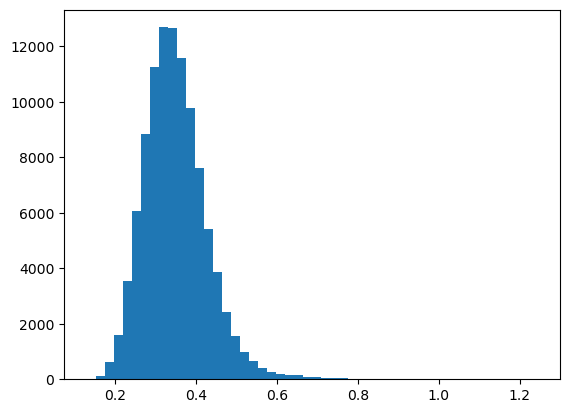

In [161]:
predictions_autoencoder_normal=autoencoder.predict(Xtest_normal)
normalclass_loss=tensorflow.keras.losses.mae(predictions_autoencoder_normal,Xtest_normal)
plt.hist(normalclass_loss[None,:],bins=50)
#plt.xlim(-10, 10)
plt.show()

4/4 [==============================] - 0s 5ms/step


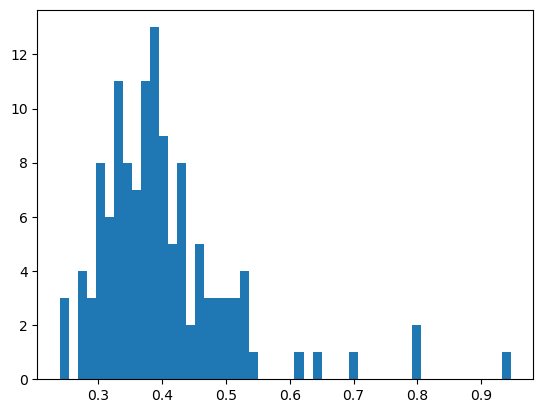

In [235]:
predictions_autoencoder_fraud=autoencoder.predict(Xtest_fraud)
fraudclass_loss=tensorflow.keras.losses.mae(predictions_autoencoder_fraud,Xtest_fraud)
plt.hist(fraudclass_loss[None,:],bins=50)
plt.show()

In [111]:
# plt.hist(normalclass_loss, bins=50, label='normal')
# plt.hist(fraudclass_loss, bins=50, label='anomaly')
# plt.axvline(threshold, color='r', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))
# plt.legend(loc='upper right')
# plt.title("Normal and Anomaly Loss")
# plt.show()

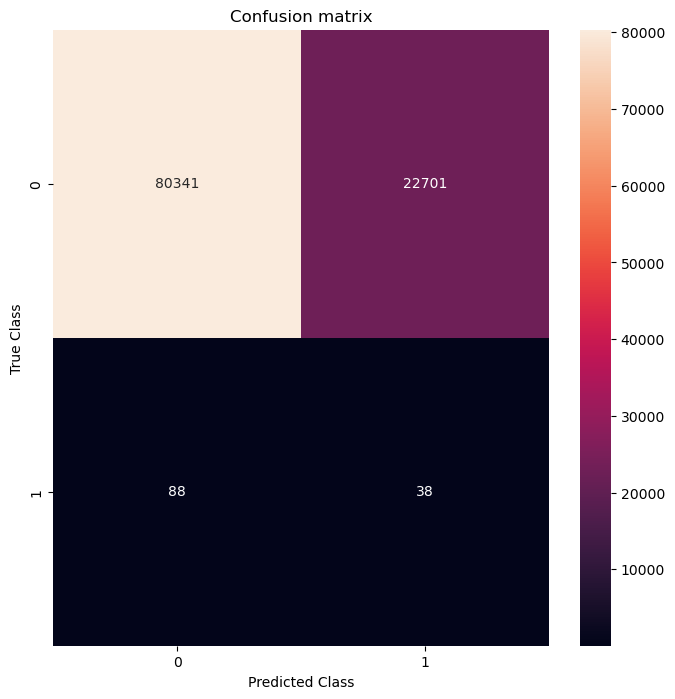

In [162]:
# confusion matrix
threshold = 0.4322
# And see how well we’re dividing the two types of transactions:
groups = error.groupby('True_class')
# predict fraud
y_pred = [1 if e > threshold else 0 for e in error.reconstruction_error.values]
conf_matrix = confusion_matrix(error.True_class, y_pred)
# plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

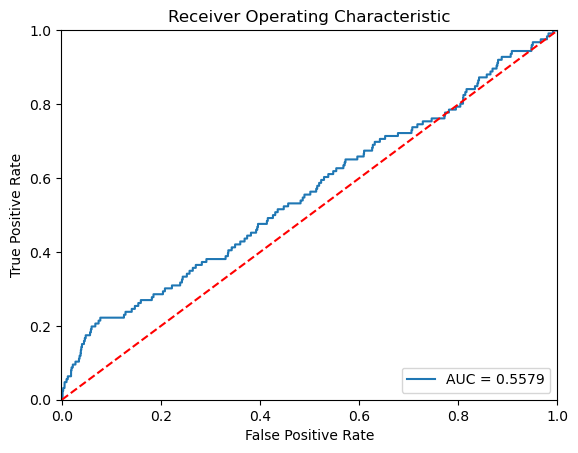

In [163]:
# ROC
fpr, tpr, thresholds = roc_curve(error.True_class, error.reconstruction_error)
roc_auc = auc(fpr, tpr)
# plot
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [247]:
# fpr, tpr, thresh = roc_curve(error.True_class, error.reconstruction_error)
# auc = roc_auc_score(error.True_class, error.reconstruction_error)

# plt.plot(fpr,tpr,label="linear in-sample, auc="+str(auc))
# plt.title('VAE roc curve - training')
# plt.ylabel('True Positive Rate')
# plt.xlabel("False Positive Rate")
# plt.legend(loc='best')
# plt.show()

### TSNE Plot to get latent representation (heavy on computation so done on a dataset of 295 fraud & 295 non fraud transactions)

In [164]:
## Undersampling for t-SNE
#print(X_train3_normal.shape, X_train3_fraud.shape)
X_normal_undersampled=X_train3_normal.sample(len(X_train3_fraud), random_state=11)
print(X_normal_undersampled.shape,X_train3_fraud.shape )

(295, 33) (295, 33)


In [165]:
df_tsne = X_train3_fraud.append(X_normal_undersampled).reset_index(drop=True)
X = df_tsne.drop(['Is Fraud?_tr'], axis = 1).values
y = df_tsne["Is Fraud?_tr"].values

/var/folders/0t/56tw317j52n02zljvtt1yxg00000gn/T/ipykernel_2258/1458565215.py:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [166]:
def tsne_plot(X, y,name, title='TSNE plot of Fraud and Non Fraud'):
    tsne = TSNE(n_components=2, random_state=24, init='random', learning_rate=200)
    X_t = tsne.fit_transform(X)

    plt.figure(figsize=(12,8))
    plt.scatter(X_t[np.where(y==0), 0], X_t[np.where(y==0), 1], color='darkorange', alpha = 0.7, label = "Non Fraud")
    plt.scatter(X_t[np.where(y==1), 0], X_t[np.where(y==1), 1], color='mediumblue', alpha = 0.7, label = "Fraud")

    plt.legend(loc='best')
    plt.title(title, fontsize=16)
    #experiment.log_figure(figure=plt)
    plt.savefig(name)
    plt.show()

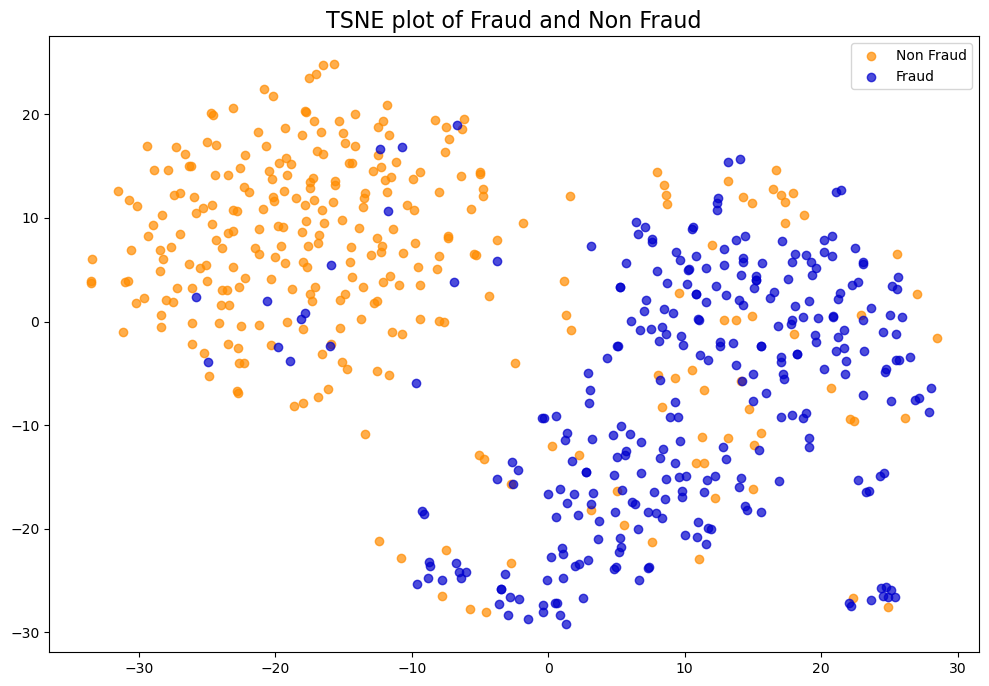

In [167]:
tsne_plot(X,y,name="TSNE_1")

In [168]:
## Representation After autoencoders
Xtrain_normal_undersampled=X_normal_undersampled.drop(['Is Fraud?_tr'], axis=1)
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])
norm_hid_rep = hidden_representation.predict(Xtrain_normal_undersampled)
fraud_hid_rep = hidden_representation.predict(Xtrain_fraud)

10/10 [==============================] - 0s 1ms/step


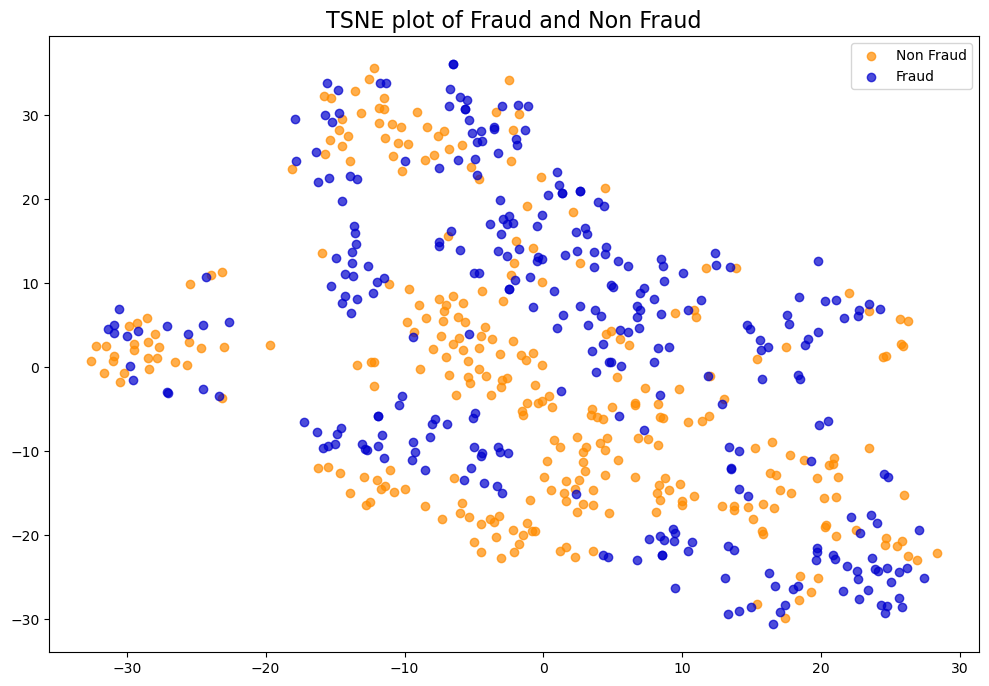

In [169]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)
tsne_plot(rep_x, rep_y, "latent_representation.png")